In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
import ast
from collections import Counter
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
import os
import seaborn as sns
from sklearn.decomposition import PCA

### Set Plotting style

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update({
    # 'figure.figsize': (3.35, 2.5),   # 单栏尺寸
    'font.family': 'Arial',
    'axes.labelsize': 7,
    'axes.titlesize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.linewidth': 0.75,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 2,
    'ytick.major.size': 2,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'legend.loc': 'upper right'
})

### Task distribution

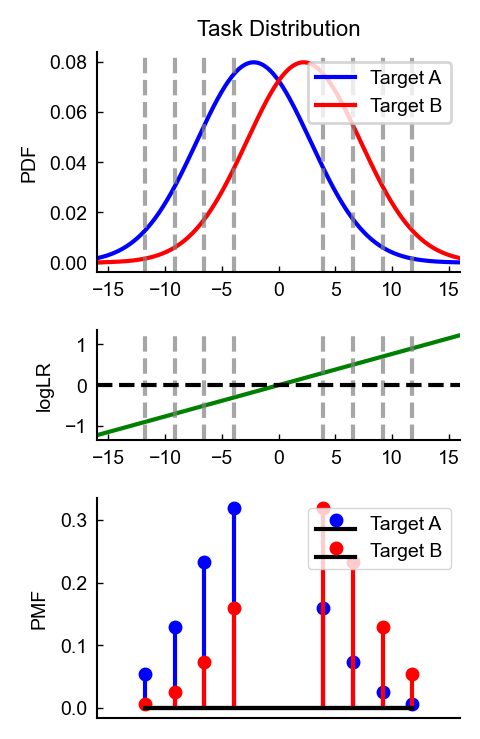

In [4]:
# Parameters for the symmetric Gaussians
mu = 2.2   # distance from y=0
sigma = 5.0
x = np.linspace(-16, 16, 500)

# Two symmetric Gaussian PDFs
pdf_left = norm.pdf(x, -mu, sigma)
pdf_right = norm.pdf(x, mu, sigma)

# Log ratio of PDFs
log_ratio = np.log10(pdf_right / pdf_left)

# Define target log ratio values
target_log_ratios = np.array([-0.9, -0.7, -0.5, -0.3, 0.3, 0.5, 0.7, 0.9])
# target_log_ratios = np.linspace(-0.9, 0.9, 8)

# Find corresponding x values by interpolation
x_targets = np.interp(target_log_ratios, log_ratio, x)

# Plot with vertical lines at target x values
fig, ax = plt.subplots(3, 1, figsize=(2.5, 3.8), gridspec_kw={'height_ratios': [2, 1, 2]})

pB_raw = norm.pdf(x_targets, mu, sigma)
pA_raw = norm.pdf(x_targets, -mu, sigma)

# Normalize
pB = pB_raw / pB_raw.sum()
pA = pA_raw / pA_raw.sum()

# Top plot: PDFs
ax[0].plot(x, pdf_left, label='Target A', color='blue')
ax[0].plot(x, pdf_right, label='Target B', color='red')
for xt in x_targets:
    ax[0].axvline(xt, color='gray', linestyle='--', alpha=0.7)
ax[0].set_xlim(-16, 16)
ax[0].set_xticks(range(-15, 16, 5))
# ax[0].set_xlabel('x')
ax[0].set_ylabel('PDF')
ax[0].legend()
ax[0].set_title('Task Distribution')

# middle plot: Log ratio
ax[1].plot(x, log_ratio, color='green')
for xt in x_targets:
    ax[1].axvline(xt, color='gray', linestyle='--', alpha=0.7)
ax[1].axhline(0, color='black', linestyle='--')
ax[1].set_xlim(-16, 16)
ax[1].set_xticks(range(-15, 16, 5))
# ax[1].set_xlabel('x')
ax[1].set_ylabel('logLR')

# bottom plot: Probability
markerline1, stemlines1, baseline1 = ax[2].stem(x_targets, pA, linefmt='b-', markerfmt='bo', basefmt='k-', label='Target A')
markerline2, stemlines2, baseline2 = ax[2].stem(x_targets, pB, linefmt='r-', markerfmt='ro', basefmt='k-', label='Target B')
markerline1.set_markersize(4)
markerline2.set_markersize(4)
ax[2].legend()
ax[2].set_xlim(-16, 16)
# ax[2].set_ylim(0, 0.25)
ax[2].set_xlabel('x')
ax[2].set_ylabel('PMF')

# hide the xticks
ax[2].set_xticks([])
# hide the xlabel
ax[2].set_xlabel('')

leg2 = ax[2].get_legend()
leg2.get_frame().set_linewidth(0.5)
for lh in leg2.get_lines():
    lh.set_linewidth(1.0)
    lh.set_markersize(3.0)

plt.tight_layout()

# save the figure to svg
plt.savefig('distribution.svg', dpi=300)

plt.show()

### Load the data
Add information to the dataframe:

In [78]:
path = '/Users/lijialin/Desktop/Research/SPRT/OriginalSPRT/results/exp_reward=1.0_sample_cost=0.01_urgency_cost=0.00_logLR=[-0.9,0.9]_max_samples=10_max_steps= 10000_epNum=1500000/'

df= pd.read_json(path + 'data.json', lines=True)

# decision time
episode_lengths = df.groupby('episode').size().reset_index(name='decision_time')
df = df.merge(episode_lengths, on='episode', how='left')
df["decision_time"] = df["decision_time"] - 1

# timesteps
df['time_step'] = df['stimuli_so_far'].apply(len)

# evidence
df["evidences"] = df.apply(lambda row: [target_log_ratios[s] for s in row["stimuli_so_far"][:row["decision_time"]]], axis=1)
df["evidence_sum"] = df["evidences"].apply(sum)

# policy
df['p_chooseA'] = df['policy'].apply(lambda p: p[0])
df['p_chooseB'] = df['policy'].apply(lambda p: p[1])
df['p_sample'] = df['policy'].apply(lambda p: p[2])
df['log_ratio'] = np.log10(df['p_chooseA'] / df['p_chooseB'].replace(0, np.nan)) # replace 0 with nan to avoid log(0)

# calculate the accuracy
correct_data = df[df["correct_answer"] == df["action"]].copy()

print('total correct trials:', len(correct_data))
correct_data_0 = correct_data[correct_data["correct_answer"] == 0]
correct_data_1 = correct_data[correct_data["correct_answer"] == 1]
print('correct trials for A:', len(correct_data_0))
print('correct trials for B:', len(correct_data_1))

df.head()
print(df.shape)

total correct trials: 44451
correct trials for A: 22674
correct trials for B: 21777
(249436, 16)


/Users/lijialin/miniconda3/envs/daily/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Basic Metrics

In [90]:
df[(df["decision_time"] == 11) & (df["episode"] == 10)]

,episode,correct_answer,stimuli_so_far,current_stimulus,action,reward,policy,hidden_state,decision_time,time_step,evidences,evidence_sum,p_chooseA,p_chooseB,p_sample,log_ratio
50,10,1,[],-1,2,-0.01,"[0.0007608356000000001, 0.0017075512000000001,...","[-0.0997212529, 0.0019043286, 0.1162103042, -0...",11,0,[],0.000000e+00,0.000761,0.001708,0.997532,-0.351083
51,10,1,[3],3,2,-0.01,"[0.0231452435, 7.19735e-05, 0.9767827988000001]","[-0.1477663964, -0.06884740290000001, 0.076829...",11,1,[-0.3],-3.000000e-01,0.023145,0.000072,0.976783,2.507289
52,10,1,"[3, 6]",6,2,-0.01,"[3.70537e-05, 0.039247632000000005, 0.9607153535]","[0.0036156997000000002, 0.031007967900000002, ...",11,2,"[-0.3, 0.7]",4.000000e-01,0.000037,0.039248,0.960715,-3.024982
53,10,1,"[3, 6, 3]",3,2,-0.01,"[0.0008637189000000001, 0.0026710005, 0.996465...","[-0.09006535260000001, -0.0318735652, -0.01684...",11,3,"[-0.3, 0.7, -0.3]",1.000000e-01,0.000864,0.002671,0.996465,-0.490302
54,10,1,"[3, 6, 3, 5]",5,2,-0.01,"[1.56739e-05, 0.1473064274, 0.8526779413000001]","[0.018553186200000002, 0.0641464144, -0.064617...",11,4,"[-0.3, 0.7, -0.3, 0.5]",6.000000e-01,0.000016,0.147306,0.852678,-3.973045
55,10,1,"[3, 6, 3, 5, 2]",2,2,-0.01,"[0.0041195457, 0.003164582, 0.9927158952]","[-0.0770124272, -0.1229520291, -0.1180533841, ...",11,5,"[-0.3, 0.7, -0.3, 0.5, -0.5]",1.000000e-01,0.004120,0.003165,0.992716,0.114533
56,10,1,"[3, 6, 3, 5, 2, 2]",2,2,-0.01,"[0.28211289640000003, 6.72043e-05, 0.7178198695]","[-0.1623016894, -0.200463295, -0.2210122794, -...",11,6,"[-0.3, 0.7, -0.3, 0.5, -0.5, -0.5]",-4.000000e-01,0.282113,0.000067,0.717820,3.623026
57,10,1,"[3, 6, 3, 5, 2, 2, 6]",6,2,-0.01,"[0.0089901229, 0.0814739391, 0.9095359445000001]","[-0.0401194021, -0.0222235546, -0.3294934034, ...",11,7,"[-0.3, 0.7, -0.3, 0.5, -0.5, -0.5, 0.7]",3.000000e-01,0.008990,0.081474,0.909536,-0.957253
58,10,1,"[3, 6, 3, 5, 2, 2, 6, 3]",3,2,-0.01,"[0.17031437160000001, 0.009834730100000001, 0....","[-0.15295632180000002, -0.0458688736, -0.42595...",11,8,"[-0.3, 0.7, -0.3, 0.5, -0.5, -0.5, 0.7, -0.3]",-5.551115e-17,0.170314,0.009835,0.819851,1.238489
59,10,1,"[3, 6, 3, 5, 2, 2, 6, 3, 3]",3,2,-0.01,"[0.5361581445, 0.001490032, 0.4623518586]","[-0.1956865042, -0.0748477429, -0.5554500818, ...",11,9,"[-0.3, 0.7, -0.3, 0.5, -0.5, -0.5, 0.7, -0.3, ...",-3.000000e-01,0.536158,0.001490,0.462352,2.556097


In [85]:
df_decision = df[df["action"] != 2].dropna(subset=["decision_time"])
df_decision.head()

,episode,correct_answer,stimuli_so_far,current_stimulus,action,reward,policy,hidden_state,decision_time,time_step,evidences,evidence_sum,p_chooseA,p_chooseB,p_sample,log_ratio
2,0,0,"[4, 7]",7,1,0.0,"[3.31e-08, 0.46298801900000003, 0.537011981]","[0.1777110696, 0.1615951955, 0.0743832141, 0.0...",2,2,"[0.3, 0.9]",1.2,3.310000e-08,0.462988,0.537012,-7.145742
6,1,1,"[5, 6, 3]",3,1,1.0,"[1.85e-07, 0.2781313956, 0.7218683958000001]","[0.023856436800000002, 0.0419245623, 0.0776366...",3,3,"[0.5, 0.7, -0.3]",0.9,1.850000e-07,0.278131,0.721868,-6.177078
15,2,1,"[5, 6, 5, 3, 4, 6, 4, 5]",5,1,1.0,"[0.0, 0.5705109239, 0.4294890463]","[0.3672062457, 0.24917134640000002, 0.10356551...",8,8,"[0.5, 0.7, 0.5, -0.3, 0.3, 0.7, 0.3, 0.5]",3.2,0.000000e+00,0.570511,0.429489,-inf
20,3,0,"[4, 3, 2, 3]",3,0,1.0,"[0.4585626423, 1.5809e-06, 0.5414357185]","[-0.2099556178, -0.1780172884, -0.1071058661, ...",4,4,"[0.3, -0.3, -0.5, -0.3]",-0.8,4.585626e-01,0.000002,0.541436,5.462494
25,4,1,"[4, 5, 4, 4]",4,1,1.0,"[6.7000000000000004e-09, 0.4932741225, 0.50672...","[0.12498088930000001, 0.2019574195, 0.12242967...",4,4,"[0.3, 0.5, 0.3, 0.3]",1.4,6.700000e-09,0.493274,0.506726,-7.867014


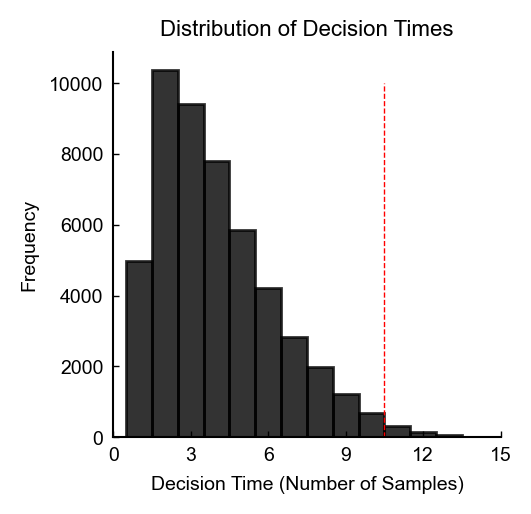

total trials: 50000
trials with decision time above 10: 538


In [80]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

# histogram
ax.hist(df_decision["decision_time"], 
        bins=range(1, int(df_decision["decision_time"].max()) + 2),
        edgecolor='black', align='left', color = 'black', alpha = 0.8)
ax.vlines(10.5, 0, 10000, color = 'red', linestyle = '--', linewidth = 0.5)
ax.set_xlabel("Decision Time (Number of Samples)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Decision Times")
ax.set_xlim(0, 15)
ax.set_xticks(range(0, 16, 3))

# plt.savefig('dt_dist_inf.svg', dpi=300)
plt.show()

# count how many trials decision time is above 10
print('total trials:', len(df_decision))
print('trials with decision time above 10:', len(df_decision[df_decision["decision_time"] > 10]))

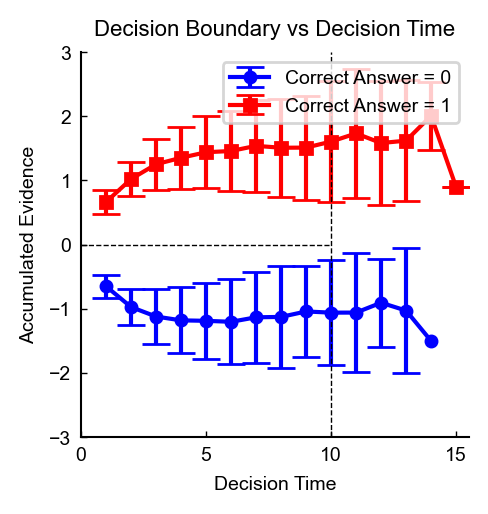

In [81]:
# remove trials when agent responded incorrectly
correct_data = df_decision[df_decision["correct_answer"] == df_decision["action"]].copy()

# separate into groups based on correct_answer value
correct_data_0 = correct_data[correct_data["correct_answer"] == 0]
correct_data_1 = correct_data[correct_data["correct_answer"] == 1]

grouped0_stats = correct_data_0.groupby("decision_time")["evidence_sum"].agg(["mean", "std", "count"])
grouped1_stats = correct_data_1.groupby("decision_time")["evidence_sum"].agg(["mean", "std", "count"])

# remove the decision time where the count is less than 5
# grouped0_stats = grouped0_stats[grouped0_stats["count"] >= 100]
# grouped1_stats = grouped1_stats[grouped1_stats["count"] >= 100]

# remove the decision time more than 20
grouped0_stats = grouped0_stats[grouped0_stats.index <= 15]
grouped1_stats = grouped1_stats[grouped1_stats.index <= 15]

grouped0_stats = grouped0_stats[grouped0_stats.index > 0]
grouped1_stats = grouped1_stats[grouped1_stats.index > 0]

# compute 95% confidence intervals
grouped0_stats["ci95"] = 1.96 * grouped0_stats["std"] / np.sqrt(grouped0_stats["count"])
grouped1_stats["ci95"] = 1.96 * grouped1_stats["std"] / np.sqrt(grouped1_stats["count"])

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.errorbar(grouped0_stats.index, grouped0_stats["mean"], 
             yerr=grouped0_stats["std"], fmt='o-', capsize=5, label="Correct Answer = 0", color='blue', markersize=4)
ax.errorbar(grouped1_stats.index, grouped1_stats["mean"], 
             yerr=grouped1_stats["std"], fmt='s-', capsize=5, label="Correct Answer = 1", color='red', markersize=4)
ax.hlines(0, 0, 10, color='black', linestyle='--', linewidth=0.5)
ax.vlines(10, -3, 3, color = 'black', linestyle = '--', linewidth = 0.5)
ax.set_xlim(0, 15.5)
ax.set_ylim(-3, 3)
ax.set_xlabel("Decision Time")
ax.set_ylabel("Accumulated Evidence")
ax.set_title("Decision Boundary vs Decision Time")
ax.legend()
# ax.grid(True)

# plt.savefig('logLR_bound_inf.svg', dpi=300)
plt.show()

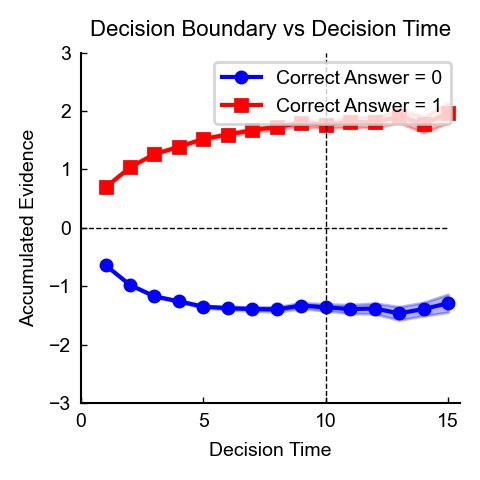

In [158]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

# Plot for correct_answer == 0
x0 = grouped0_stats.index
y0 = grouped0_stats["mean"]
ci0 = grouped0_stats["ci95"]

ax.plot(x0, y0, color='blue', label="Correct Answer = 0", marker='o', markersize=4)
ax.fill_between(x0, y0 - ci0, y0 + ci0, color='blue', alpha=0.3)

# Plot for correct_answer == 1
x1 = grouped1_stats.index
y1 = grouped1_stats["mean"]
ci1 = grouped1_stats["ci95"]

ax.plot(x1, y1, color='red', label="Correct Answer = 1", marker='s', markersize=4)
ax.fill_between(x1, y1 - ci1, y1 + ci1, color='red', alpha=0.3)

# reference lines
ax.hlines(0, 0, 15, color='black', linestyle='--', linewidth=0.5)
ax.vlines(10, -3, 3, color='black', linestyle='--', linewidth=0.5)

# labels and limits
ax.set_xlim(0, 15.5)
ax.set_ylim(-3, 3)
ax.set_xlabel("Decision Time")
ax.set_ylabel("Accumulated Evidence")
ax.set_title("Decision Boundary vs Decision Time")
ax.legend()
# ax.grid(True)

# save or show
# plt.savefig('logLR_bound_inf_CI95_filled.svg', dpi=300)
plt.tight_layout()
plt.show()

/var/folders/j5/y5g6mhcd7wg0lg4_wsdrql7r0000gn/T/ipykernel_2079/2370809367.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  psychometric_data = psychometric_data.groupby("evidence_sum_binned")["action"].mean().reset_index()


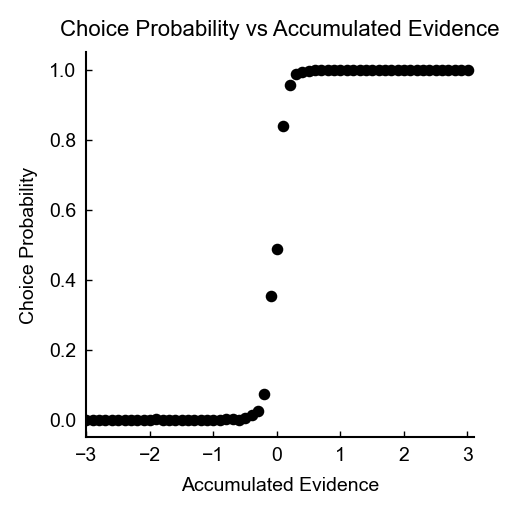

In [135]:
bin_width = 0.01
bin_start = -3
bin_end = 3.1

psychometric_data = df_decision.groupby(['episode']).last().reset_index()
# bin the evidence_sum
psychometric_data["evidence_sum_binned"] = pd.cut(psychometric_data["evidence_sum"], 
                                         bins=np.arange(bin_start, bin_end, bin_width), 
                                         labels=np.arange(bin_start + bin_width/2, bin_end - bin_width/2, bin_width))

psychometric_data = psychometric_data.groupby("evidence_sum_binned")["action"].mean().reset_index()

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.scatter(psychometric_data["evidence_sum_binned"], psychometric_data["action"], s = 10, color = 'black')
ax.set_xlim(-3, 3.1)
ax.set_xticks(np.arange(-3, 3.1, 1))
ax.set_xlabel("Accumulated Evidence")
ax.set_ylabel("Choice Probability")
ax.set_title("Choice Probability vs Accumulated Evidence")

# plt.savefig('psychMetric_inf.svg', dpi=300)
plt.show()

Logistic regression: subjective weights assigned to each stimulus
$$
P(choose \ A) = \frac{1}{1 + e^{-Q}}
$$
where
$$
Q = \sum_{i=1}^8 \beta_i n_i
$$
$n_i$ is the number of times the stimulus is presented in each trial

In [11]:
df_last = df.groupby("episode").last()
stimuli_counts = df_last["stimuli_so_far"].apply(Counter)
stimuli_df = pd.DataFrame.from_records(stimuli_counts).fillna(0).astype(int)

stimuli_df = stimuli_df[sorted(stimuli_df.columns)]
stimuli_df["action"] = df_last["action"]

stimuli_df.head()

,0,1,2,3,4,5,6,7,action
0,0,1,0,0,1,1,0,1,1
1,0,2,0,1,0,0,0,0,0
2,0,0,0,1,2,1,1,0,1
3,0,1,0,0,0,0,0,0,0
4,0,0,0,2,3,1,0,0,1


In [13]:
# X is the features, y is the target
X = stimuli_df.drop(columns=['action'])
y = stimuli_df['action']

# fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# get the coefficients and intercept
coef_natural = pd.Series(model.coef_[0], index=X.columns)
intercept_natural = model.intercept_[0]

# sort the coefficients by stimulus value
coef_natural = coef_natural.sort_index()


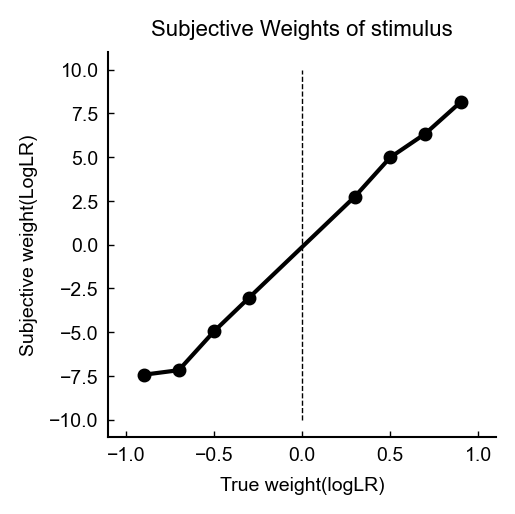

In [14]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.plot(target_log_ratios, coef_natural, 'o-', color = 'black', markersize = 4)
ax.vlines(0, -10, 10, color='black', linestyle='--', linewidth = 0.5)
ax.set_xlim(-1.1, 1.1)
ax.set_xticks(np.arange(-1.0, 1.1, 0.5))
ax.set_xlabel("True weight(logLR)")
ax.set_ylabel("Subjective weight(LogLR)")
ax.set_title("Subjective Weights of stimulus")
# ax.grid(True)

# plt.savefig('subjWeight_inf.svg', dpi=300)
plt.show()

## Model policy

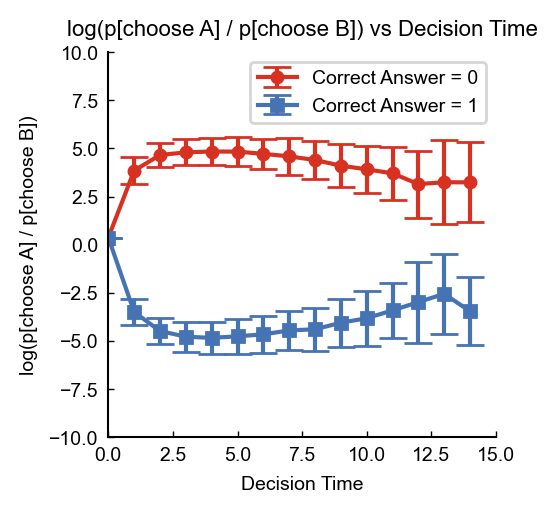

In [22]:
grouped0_stats = correct_data_0.groupby("decision_time")["log_ratio"].agg(["mean", "std", "count"])
grouped1_stats = correct_data_1.groupby("decision_time")["log_ratio"].agg(["mean", "std", "count"])

# remove the decision time where the count is less than 5
grouped0_stats = grouped0_stats[grouped0_stats["count"] >= 10]
grouped1_stats = grouped1_stats[grouped1_stats["count"] >= 10]

grouped0_stats = grouped0_stats[grouped0_stats.index <= 20]
grouped1_stats = grouped1_stats[grouped1_stats.index <= 20]

# plot the mean of log_ratio vs decision_time
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.errorbar(grouped0_stats.index, grouped0_stats["mean"], 
             yerr=grouped0_stats["std"], fmt='o-', capsize=5, label="Correct Answer = 0", color='#d73221', markersize = 4)
ax.errorbar(grouped1_stats.index, grouped1_stats["mean"], 
             yerr=grouped1_stats["std"], fmt='s-', capsize=5, label="Correct Answer = 1", color='#4573b4', markersize = 4)
ax.set_xlabel("Decision Time")
ax.set_ylabel("log(p[choose A] / p[choose B])")
ax.set_title("log(p[choose A] / p[choose B]) vs Decision Time")
ax.set_ylim(-10, 10)
ax.set_xlim(0, 15)
ax.legend()
plt.show()

### Decision weight on each timestep
To examine the effect of how RNNs learn to integrate cues over time, we conduct the following logistic regression:
$$
\text{logit}(P(\text{choose B})) = \beta_0 + \sum_{t=1}^{T} \beta_t \cdot \text{logLR}_t
$$

In [82]:
df_decision.head()
decision_times = sorted(df_decision['decision_time'].unique())

# Store results
results = {}

for dt in decision_times:

    if dt > 15:
        continue
    
    # Filter data for this decision time
    dt_data = df_decision[df_decision['decision_time'] == dt].copy()
    
    if len(dt_data) < 10:  # Skip if too few samples
        print(f"  Skipping decision_time {dt}: insufficient data ({len(dt_data)} samples)")
        continue
        
    # Create feature matrix: each column represents a position in the sequence
    X = np.stack(dt_data['evidences'].values)
    y = np.where(dt_data['action'].values == 1, 1, 0)

    if X.shape[1] == 0:
        print(f"  Skipping decision_time {dt}: empty evidence sequences")
        continue
    
    # Check if we have variation in the target variable
    if len(np.unique(y)) < 2:
        print(f"  Skipping decision_time {dt}: no variation in decisions")
        continue
        
    # Fit logistic regression
    model = LogisticRegression(fit_intercept=True, max_iter=2000)
    model.fit(X, y)
    
    # Store results
    results[dt] = {
        'coefficients': model.coef_[0],
        'intercept': model.intercept_[0],
        'n_samples': len(dt_data),
        'positions': list(range(1, dt + 1)),
        'accuracy': model.score(X, y)
    }

  Skipping decision_time 0: empty evidence sequences
  Skipping decision_time 15: insufficient data (2 samples)


In [84]:
dt_data

,episode,correct_answer,stimuli_so_far,current_stimulus,action,reward,policy,hidden_state,decision_time,time_step,evidences,evidence_sum,p_chooseA,p_chooseB,p_sample,log_ratio
76159,15257,1,"[4, 3, 4, 2, 5, 5, 2, 4, 2, 5, 4]",4,1,1.0,"[0.0014235592, 0.6828622222, 0.3157141805]","[-0.0187020041, 0.1038395315, -0.8879935741, -...",15,11,"[0.3, -0.3, 0.3, -0.5, 0.5, 0.5, -0.5, 0.3, -0...",0.9,0.001424,0.682862,0.315714,-2.680958
231623,46385,1,"[4, 4, 3, 4, 2, 2, 6, 2, 4, 4, 5]",5,1,1.0,"[0.0012345628, 0.6828566194, 0.31590887900000003]","[-0.018416049, 0.10416333380000001, -0.8847522...",15,11,"[0.3, 0.3, -0.3, 0.3, -0.5, -0.5, 0.7, -0.5, 0...",0.9,0.001235,0.682857,0.315909,-2.742816


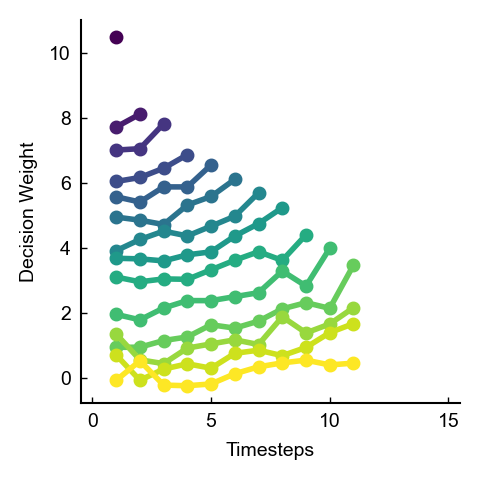

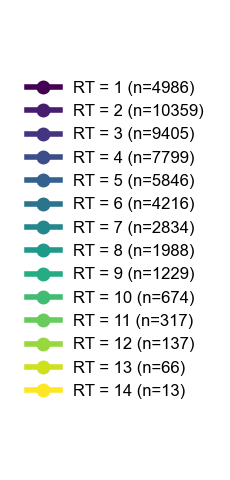

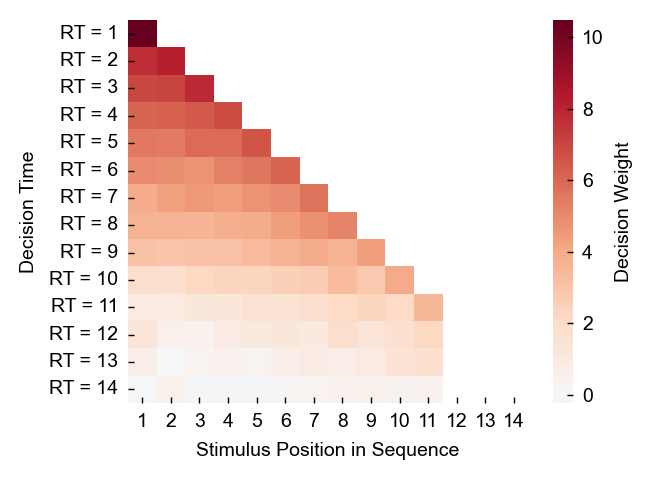

In [83]:
def plot_decision_weights(results):
    """Plot decision weights as a function of cue position for different decision times"""
    
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    colors = plt.cm.viridis(np.linspace(0, 1, len(results)))
    max_position = 0
    handles = []
    labels = []
    
    for i, (dt, data) in enumerate(results.items()):
        positions = np.array(data['positions'])
        weights = np.array(data['coefficients'])
        
        min_len = min(len(positions), len(weights))
        positions = positions[:min_len]
        weights = weights[:min_len]
        
        line, = ax.plot(positions, weights, 'o-', color=colors[i], 
                        label=f'RT = {dt} (n={data["n_samples"]})', 
                        linewidth=2, markersize=4)
        handles.append(line)
        labels.append(f'RT = {dt} (n={data["n_samples"]})')
        
        max_position = max(max_position, max(positions))
    
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Decision Weight')
    ax.set_xticks(np.arange(0, 16, 5))
    ax.set_xlim(-0.5, 15.5)
    plt.tight_layout()

    # plt.savefig('decisionWeights_inf.svg', dpi=300)
    plt.show()
    
    # ---- plot legend separately ----
    fig_leg = plt.figure(figsize=(1, 2.5))
    fig_leg.legend(handles, labels, loc='center', frameon=False, fontsize=6)
    plt.axis('off')
    plt.tight_layout()

    # plt.savefig('decisionWeights_legend_inf.svg', dpi=300)
    plt.show()

def plot_decision_weights_heatmap(results):
    """Create a heatmap showing decision weights across positions and decision times"""
    
    # Determine the maximum position across all decision times
    max_position = max(max(data['positions']) for data in results.values()) + 1
    decision_times = sorted(results.keys())
    
    # Create matrix for heatmap
    weight_matrix = np.full((len(decision_times), max_position), np.nan)
    
    for i, dt in enumerate(decision_times):    
        if dt in results:
            positions = results[dt]['positions']
            weights = results[dt]['coefficients']
            for pos, weight in zip(positions, weights):
                weight_matrix[i, pos] = weight
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(3.35, 2.5))
    
    # Create mask for missing values
    mask = np.isnan(weight_matrix)
    
    sns.heatmap(weight_matrix, 
                xticklabels=range(max_position),
                yticklabels=[f'RT = {dt}' for dt in decision_times],
                cmap='RdBu_r', center=0, 
                annot=False, fmt='.2f',
                mask=mask,
                cbar_kws={'label': 'Decision Weight'})
    
    ax.set_xlabel('Stimulus Position in Sequence')
    ax.set_ylabel('Decision Time')
    ax.set_xlim(1, 15)
    # plt.title('Decision Weights Heatmap: Position × Decision Time', fontsize=14)
    plt.tight_layout()

    # plt.savefig('decisionWeights_heatmap_inf.svg', dpi=300)
    plt.show()

fig1 = plot_decision_weights(results)
fig2 = plot_decision_weights_heatmap(results)

## Hidden States

PCA

In [322]:
df.shape

(254991, 16)

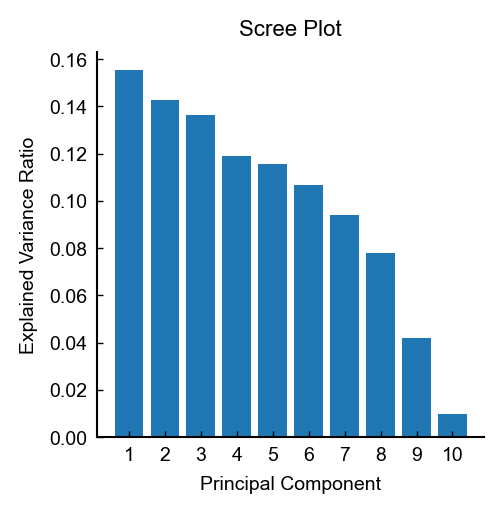

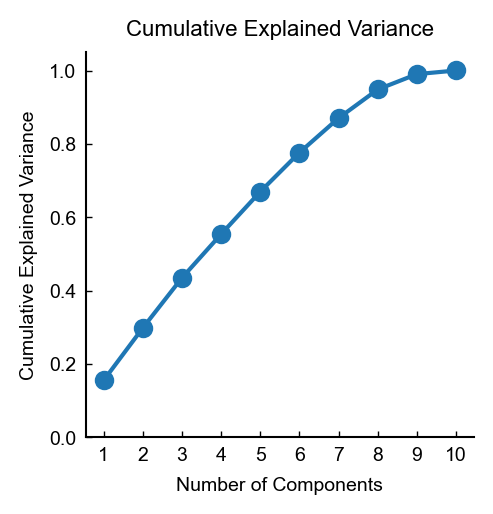

In [323]:
D = len(df.hidden_state.iloc[0])
hmat = np.vstack(df.hidden_state.values)
pca_full = PCA(n_components=10)
pca_full.fit(X)

ratios = pca_full.explained_variance_ratio_

# ---- Scree plot ----
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.bar(np.arange(1, 10 + 1), ratios[:10], align='center')
ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.xticks(np.arange(1, 10 + 1))
plt.show()

# ---- Cumulative explained variance ----
cum_ratios = np.cumsum(ratios)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.plot(np.arange(1, 10 + 1), cum_ratios[:10], marker='o')
ax.set_xlabel("Number of Components")
ax.set_ylabel("Cumulative Explained Variance")
ax.set_title("Cumulative Explained Variance")
ax.set_xticks(np.arange(1, 10 + 1))
ax.set_ylim(0,1.05)
plt.show()

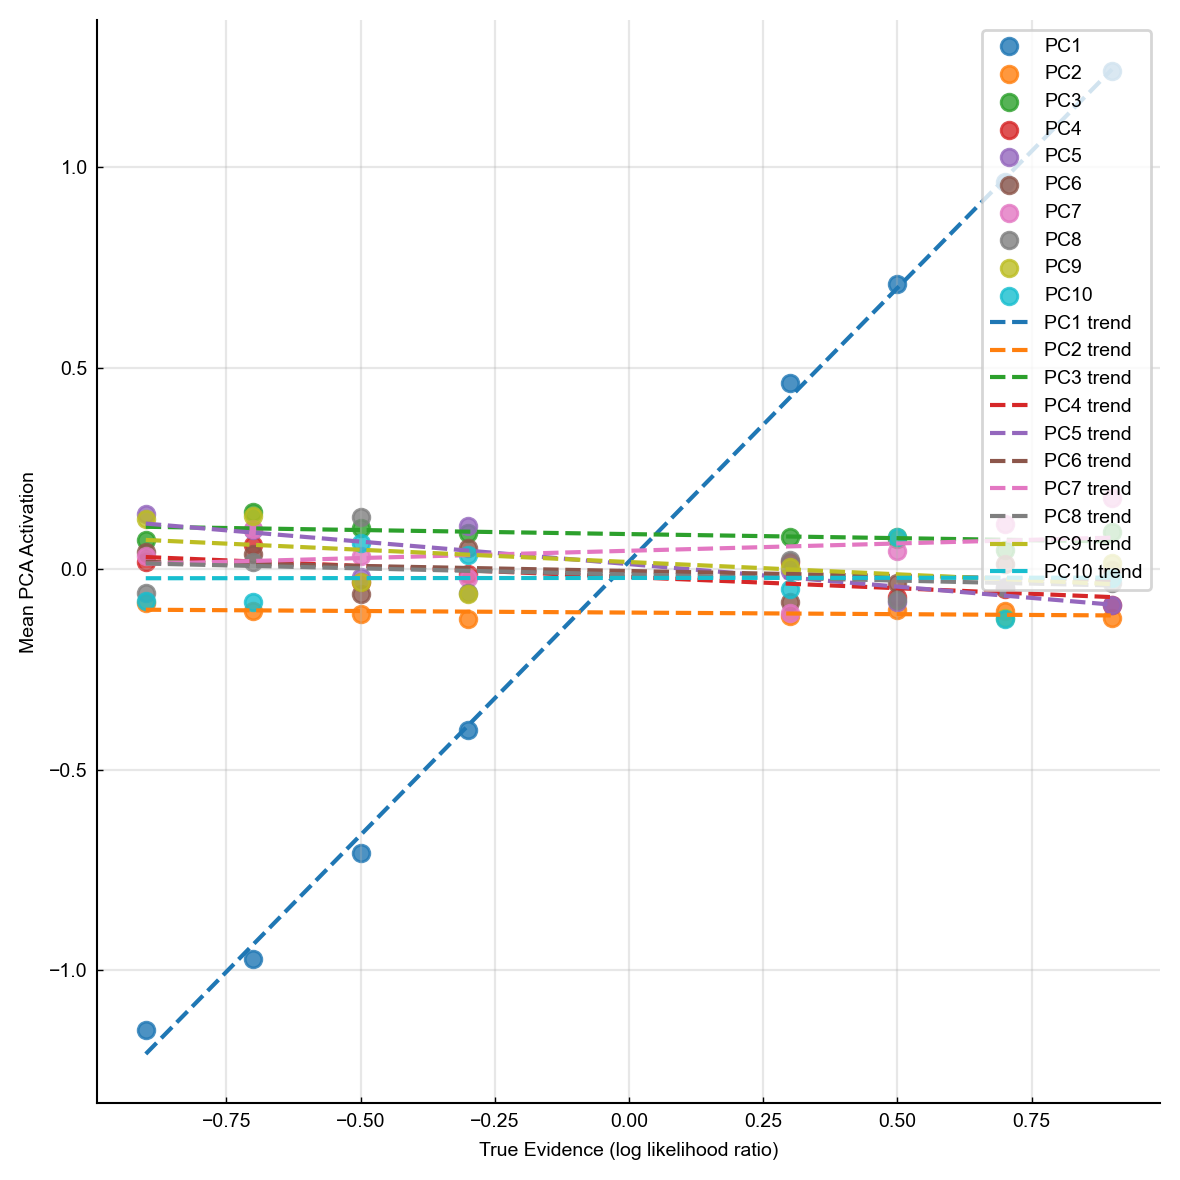

In [329]:
X = hmat  # shape (n_samples, D)
pca = PCA(n_components=10)
Z = pca.fit_transform(X)

df[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10']] = Z

df_remove0 = df[df['time_step'] != 0]

# Compute average PCA activations grouped by stimulus
grouped = df_remove0.groupby('current_stimulus')[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10']].mean().reset_index()

# Get corresponding logLR evidence values
logLRs = target_log_ratios[grouped['current_stimulus'].astype(int).values]

# Plot
plt.figure(figsize=(6, 6))

plt.scatter(logLRs, grouped['PCA1'], label='PC1', alpha=0.8)
plt.scatter(logLRs, grouped['PCA2'], label='PC2', alpha=0.8)
plt.scatter(logLRs, grouped['PCA3'], label='PC3', alpha=0.8)
plt.scatter(logLRs, grouped['PCA4'], label='PC4', alpha=0.8)
plt.scatter(logLRs, grouped['PCA5'], label='PC5', alpha=0.8)
plt.scatter(logLRs, grouped['PCA6'], label='PC6', alpha=0.8)
plt.scatter(logLRs, grouped['PCA7'], label='PC7', alpha=0.8)
plt.scatter(logLRs, grouped['PCA8'], label='PC8', alpha=0.8)
plt.scatter(logLRs, grouped['PCA9'], label='PC9', alpha=0.8)
plt.scatter(logLRs, grouped['PCA10'], label='PC10', alpha=0.8)

# Optional: fit and plot trend lines
for yvals, label in zip([grouped['PCA1'], grouped['PCA2'], grouped['PCA3'], grouped['PCA4'], grouped['PCA5'], grouped['PCA6'], grouped['PCA7'], grouped['PCA8'], grouped['PCA9'], grouped['PCA10']], ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']):
    z = np.polyfit(logLRs, yvals, 1)
    p = np.poly1d(z)
    x_line = np.linspace(logLRs.min(), logLRs.max(), 100)
    plt.plot(x_line, p(x_line), "--", label=f"{label} trend")

plt.xlabel('True Evidence (log likelihood ratio)')
plt.ylabel('Mean PCA Activation')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/j5/y5g6mhcd7wg0lg4_wsdrql7r0000gn/T/ipykernel_3115/2463886152.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_remove0.groupby('evidence_bin')[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10']].mean()
/var/folders/j5/y5g6mhcd7wg0lg4_wsdrql7r0000gn/T/ipykernel_3115/2463886152.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df_remove0.groupby('evidence_bin')['evidence_sum'].mean()


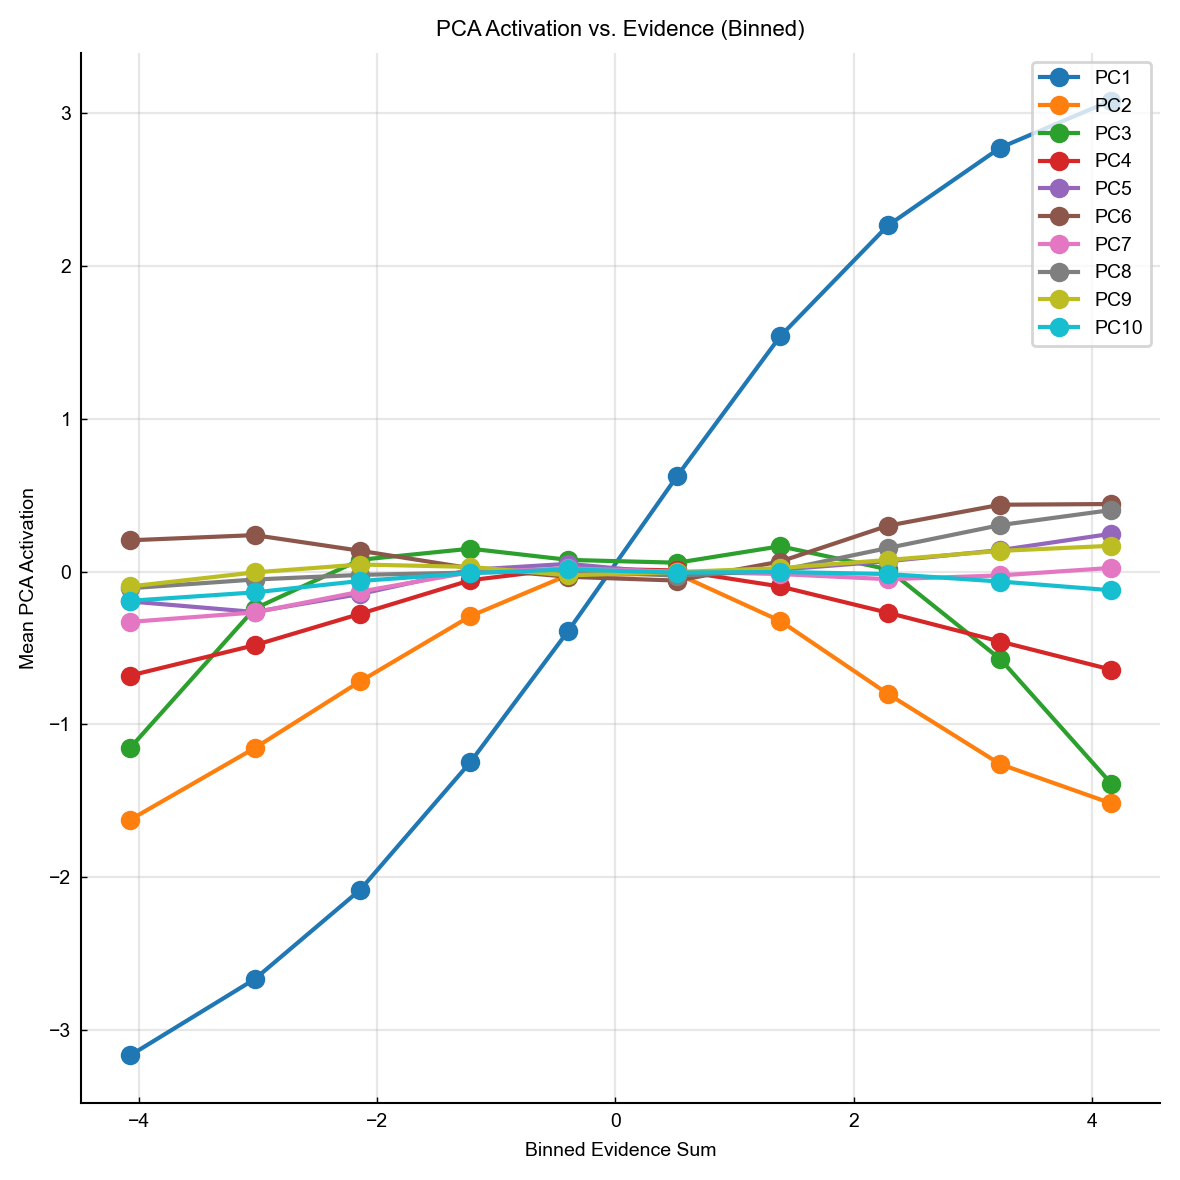

In [330]:
X = hmat  # shape (n_samples, D)
pca = PCA(n_components=10)
Z = pca.fit_transform(X)

df[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10']] = Z

# Step 2: Remove time_step == 0
df_remove0 = df[df['time_step'] != 0].copy()

# Step 3: Bin evidence_sum (you can change `n_bins` or use qcut for quantiles)
n_bins = 10
df_remove0['evidence_bin'] = pd.cut(df_remove0['evidence_sum'], bins=n_bins)

# Step 4: Group by bins and average PCA activations
grouped = df_remove0.groupby('evidence_bin')[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10']].mean()

# Compute bin centers for plotting on x-axis
bin_centers = df_remove0.groupby('evidence_bin')['evidence_sum'].mean()

# Step 5: Plot
plt.figure(figsize=(6, 6))

plt.plot(bin_centers, grouped['PCA1'], label='PC1', marker='o')
plt.plot(bin_centers, grouped['PCA2'], label='PC2', marker='o')
plt.plot(bin_centers, grouped['PCA3'], label='PC3', marker='o')
plt.plot(bin_centers, grouped['PCA4'], label='PC4', marker='o')
plt.plot(bin_centers, grouped['PCA5'], label='PC5', marker='o')
plt.plot(bin_centers, grouped['PCA6'], label='PC6', marker='o')
plt.plot(bin_centers, grouped['PCA7'], label='PC7', marker='o')
plt.plot(bin_centers, grouped['PCA8'], label='PC8', marker='o')
plt.plot(bin_centers, grouped['PCA9'], label='PC9', marker='o')
plt.plot(bin_centers, grouped['PCA10'], label='PC10', marker='o')

plt.xlabel('Binned Evidence Sum')
plt.ylabel('Mean PCA Activation')
plt.title('PCA Activation vs. Evidence (Binned)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

/Users/lijialin/miniconda3/envs/daily/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/lijialin/miniconda3/envs/daily/lib/python3.10/site-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/lijialin/miniconda3/envs/daily/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/lijialin/miniconda3/envs/daily/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/lijialin/miniconda3/envs/daily/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


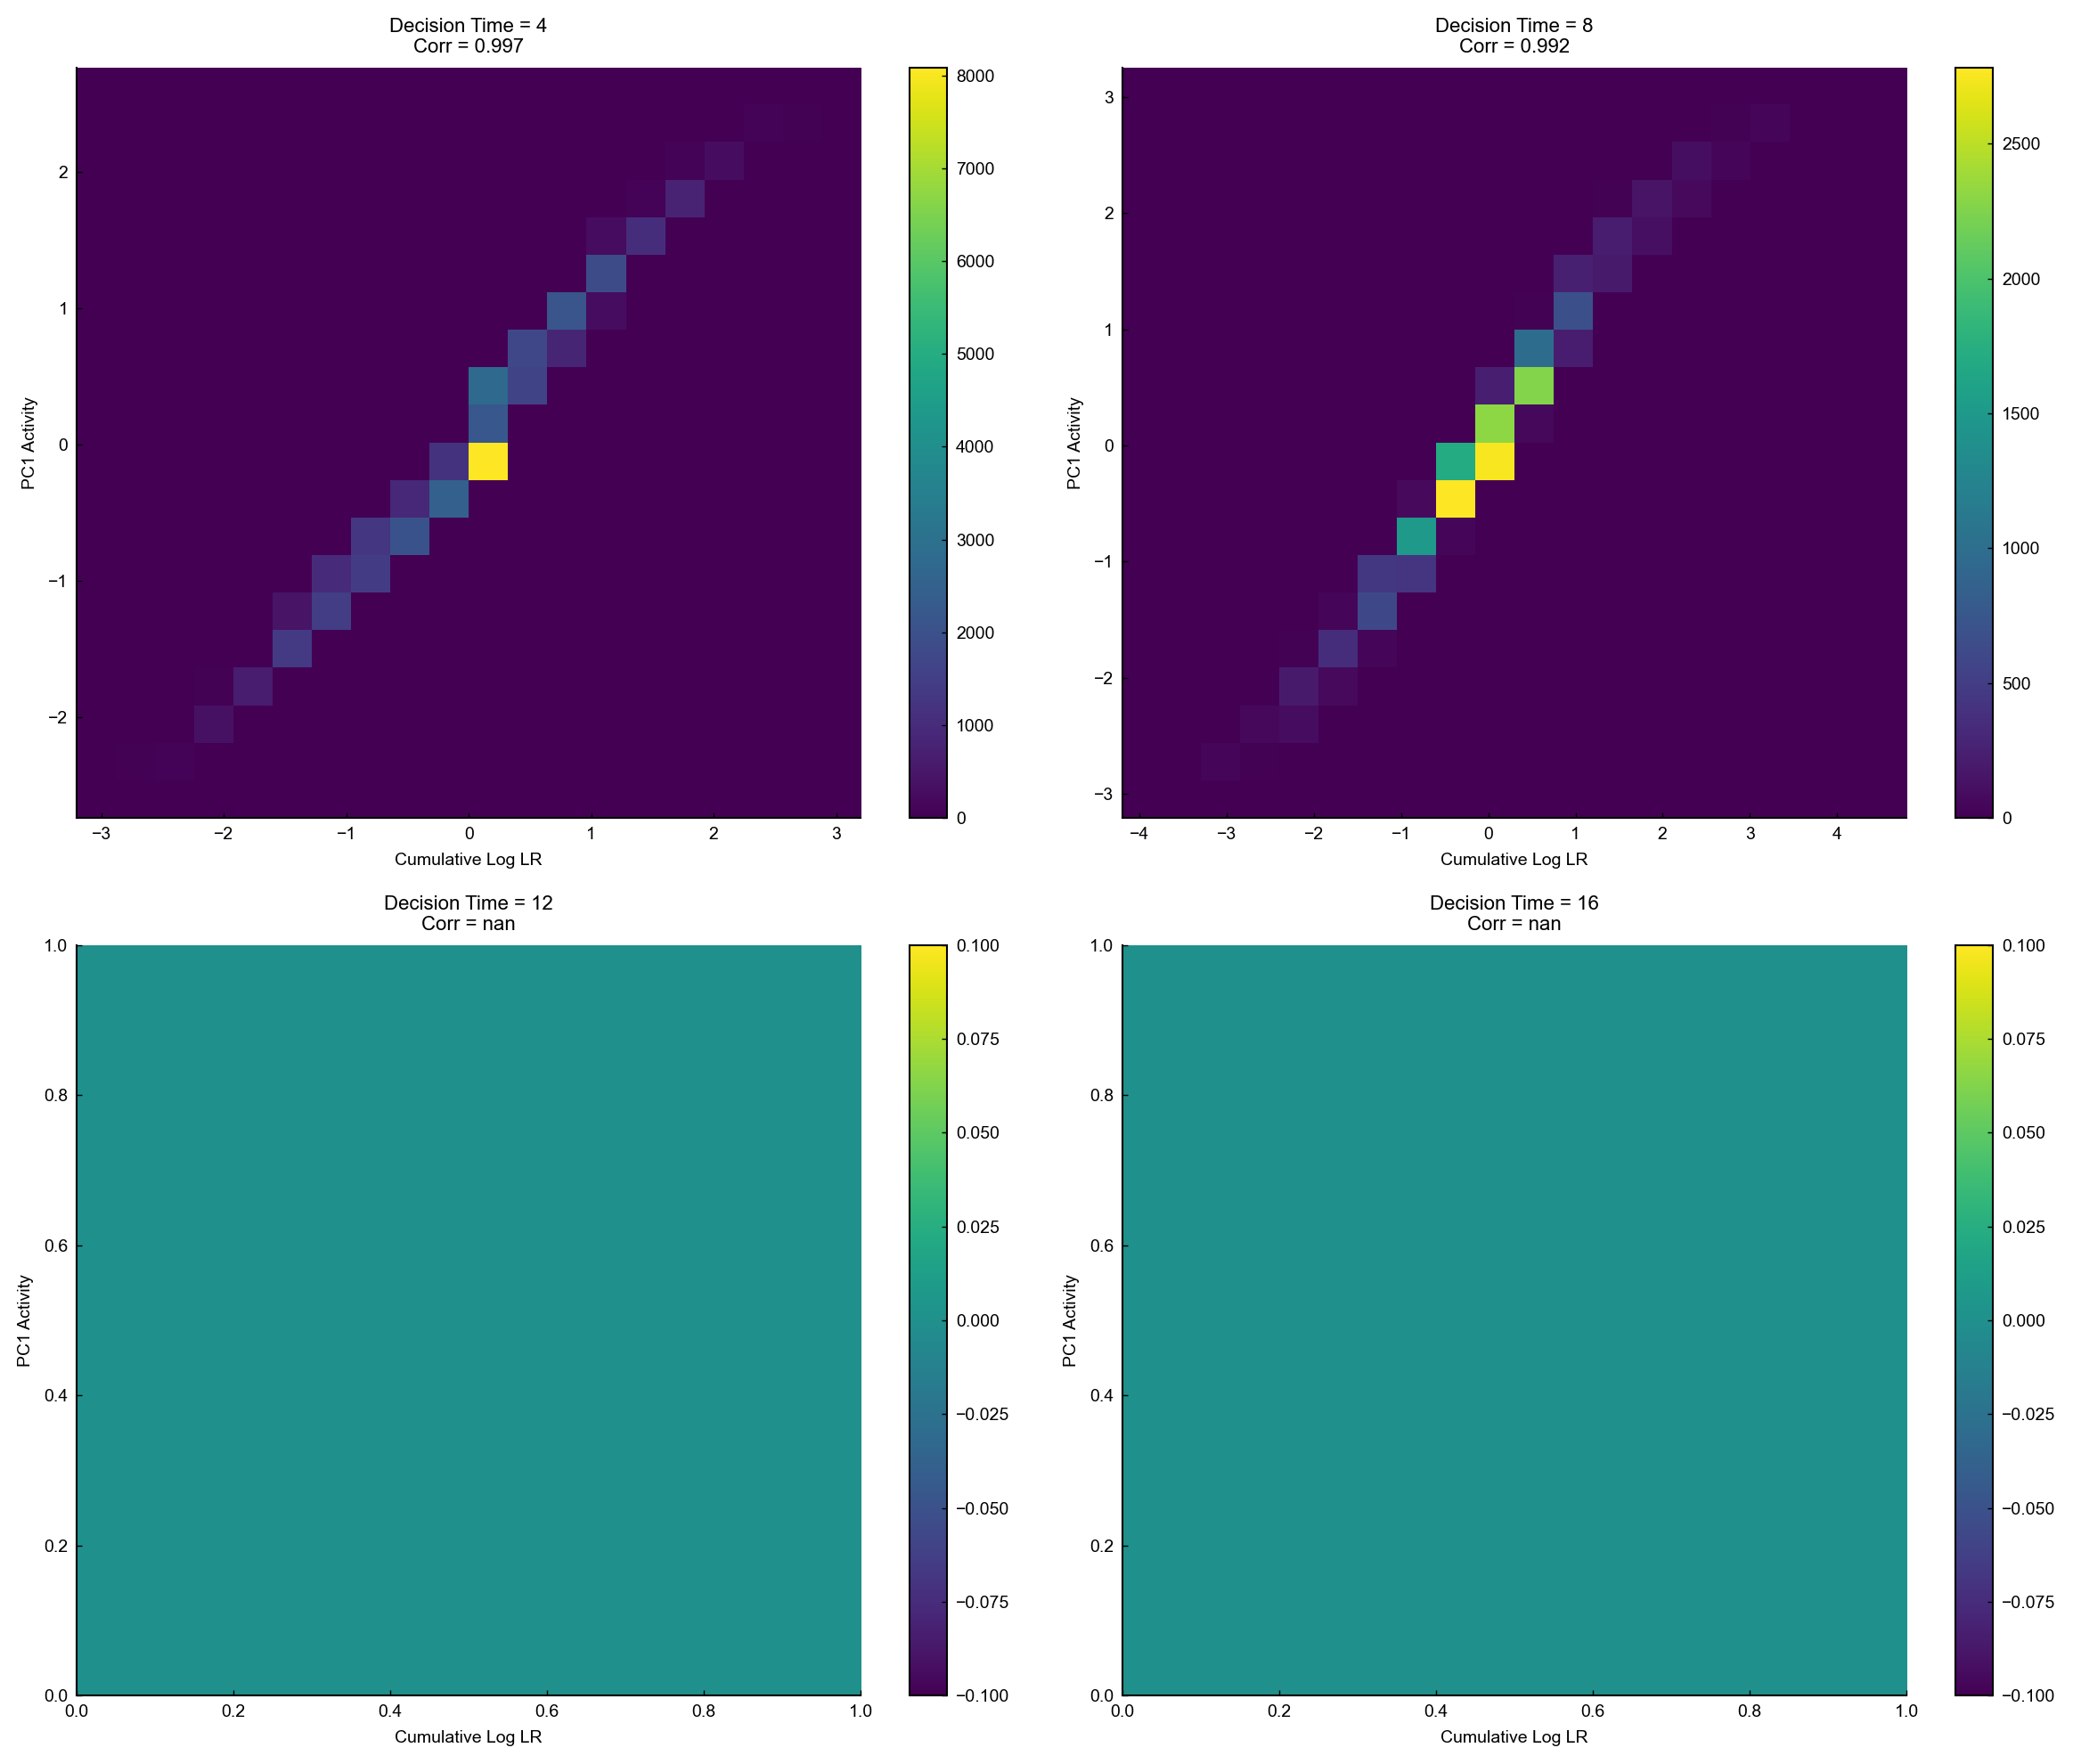

In [331]:
# Create figure with 3 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Decision times to analyze
decision_times = [4, 8, 12, 16]

for idx, dt in enumerate(decision_times):
    # Filter data for this decision time
    dt_data = df[df['decision_time'] == dt]
    
    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(
        dt_data['evidence_sum'],
        dt_data['PCA1'],
        bins=20
    )
    
    # Calculate correlation coefficient
    corr = np.corrcoef(dt_data['evidence_sum'], dt_data['PCA1'])[0,1]
    
    # Create heatmap
    im = axes[idx].imshow(hist.T, 
                         origin='lower',
                         aspect='auto',
                         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                         cmap='viridis')
    
    axes[idx].set_xlabel('Cumulative Log LR')
    axes[idx].set_ylabel('PC1 Activity')
    axes[idx].set_title(f'Decision Time = {dt}\nCorr = {corr:.3f}')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()

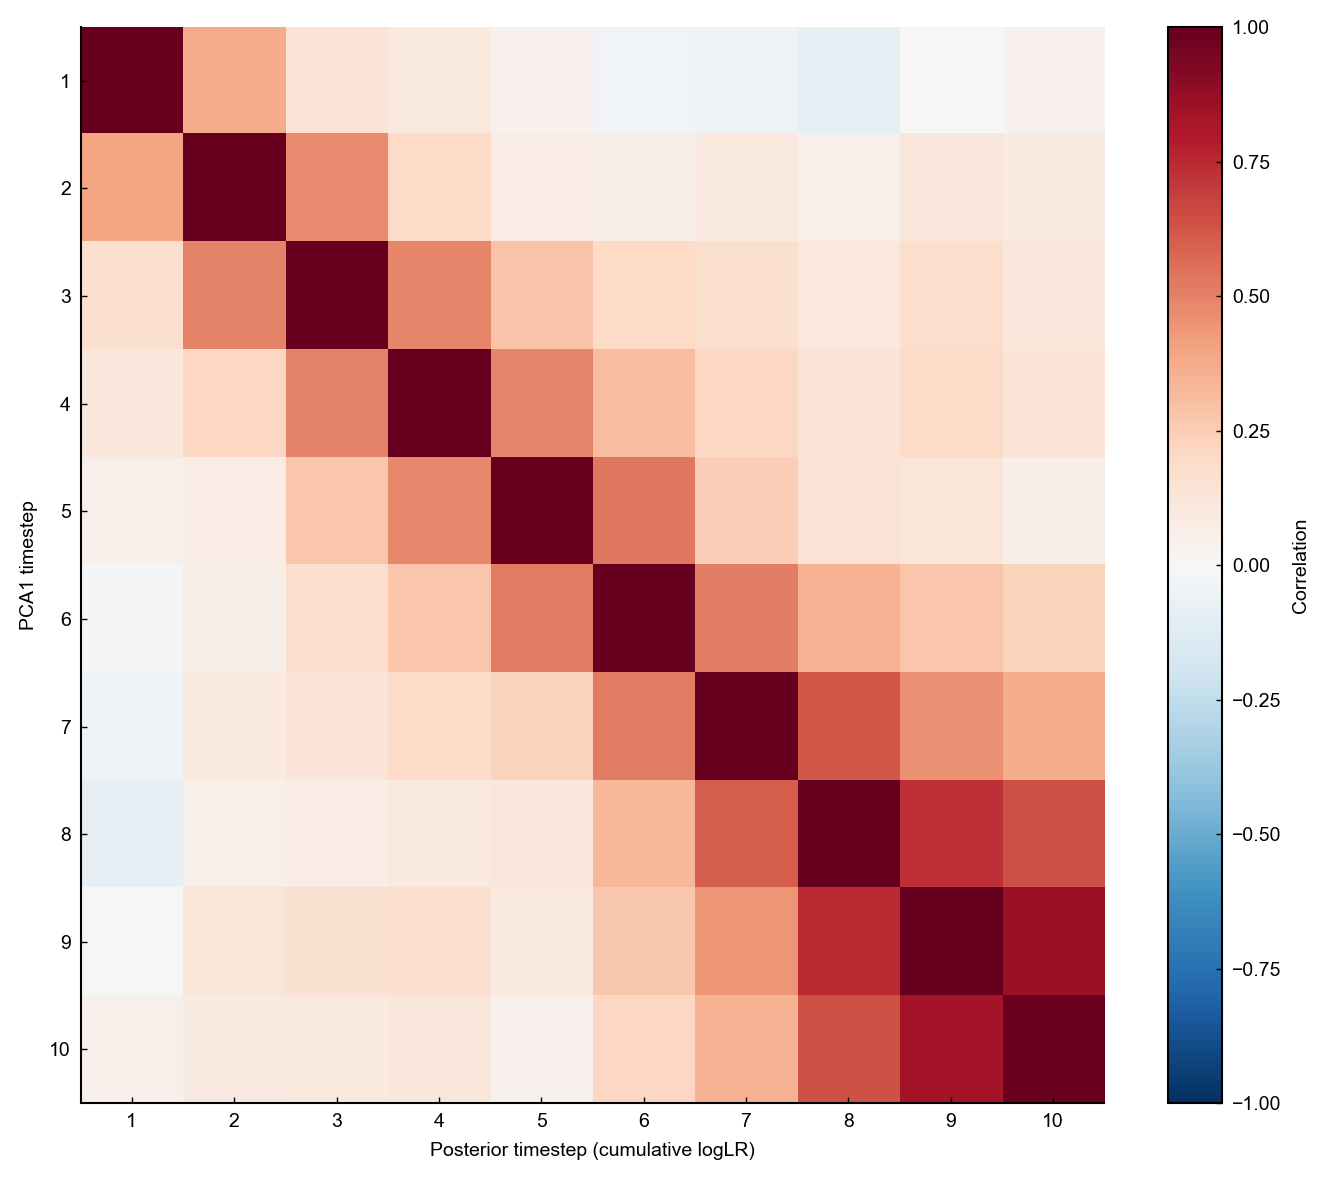

In [333]:
def plot_pc1_loglr_timestep_correlation(df, decision_time=10, pc_col='PCA1', loglr_col='evidence_sum', time_col='time_step'):
    """
    Plots a heatmap of correlations between PC1 activity and cumulative logLR
    across all timestep pairs for trials with a fixed decision time.

    Parameters:
    - df: pandas DataFrame containing PCA and logLR data
    - decision_time: the fixed decision time to filter trials (default: 10)
    - pc_col: the name of the PCA column to correlate (default: 'PCA1')
    - loglr_col: the name of the logLR column (default: 'evidence_sum')
    - time_col: the name of the time step column (default: 'time_step')
    """
    
    # Filter data for the specified decision time
    df_filtered = df[df['decision_time'] == decision_time].copy()
    max_timestep = df_filtered[time_col].max()

    # Initialize correlation matrix
    corr_matrix = np.zeros((max_timestep, max_timestep))

    # Compute correlations between PC1 and logLR across all timestep pairs
    for i in range(1, max_timestep + 1):  # PC1 timestep
        pca_data = df_filtered[df_filtered[time_col] == i][pc_col]
        
        for j in range(1, max_timestep + 1):  # logLR timestep
            lr_data = df_filtered[df_filtered[time_col] == j][loglr_col]
            
            # Only compute if both have data
            if len(pca_data) > 0 and len(lr_data) > 0:
                corr = np.corrcoef(pca_data, lr_data)[0, 1]
                corr_matrix[i - 1, j - 1] = corr

    # Plot heatmap
    plt.figure(figsize=(7, 6))
    im = plt.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    plt.colorbar(im, label='Correlation')

    plt.xlabel('Posterior timestep (cumulative logLR)')
    plt.ylabel(f'{pc_col} timestep')
    plt.xticks(range(max_timestep), range(1, max_timestep + 1))
    plt.yticks(range(max_timestep), range(1, max_timestep + 1))

    plt.tight_layout()
    plt.show()

plot_pc1_loglr_timestep_correlation(df, decision_time=10)

(8976, 26)
(29076, 26)
(36576, 26)
(39195, 26)
(36414, 26)
(31353, 26)
(24880, 26)
(19341, 26)
(25200, 26)
(3817, 26)


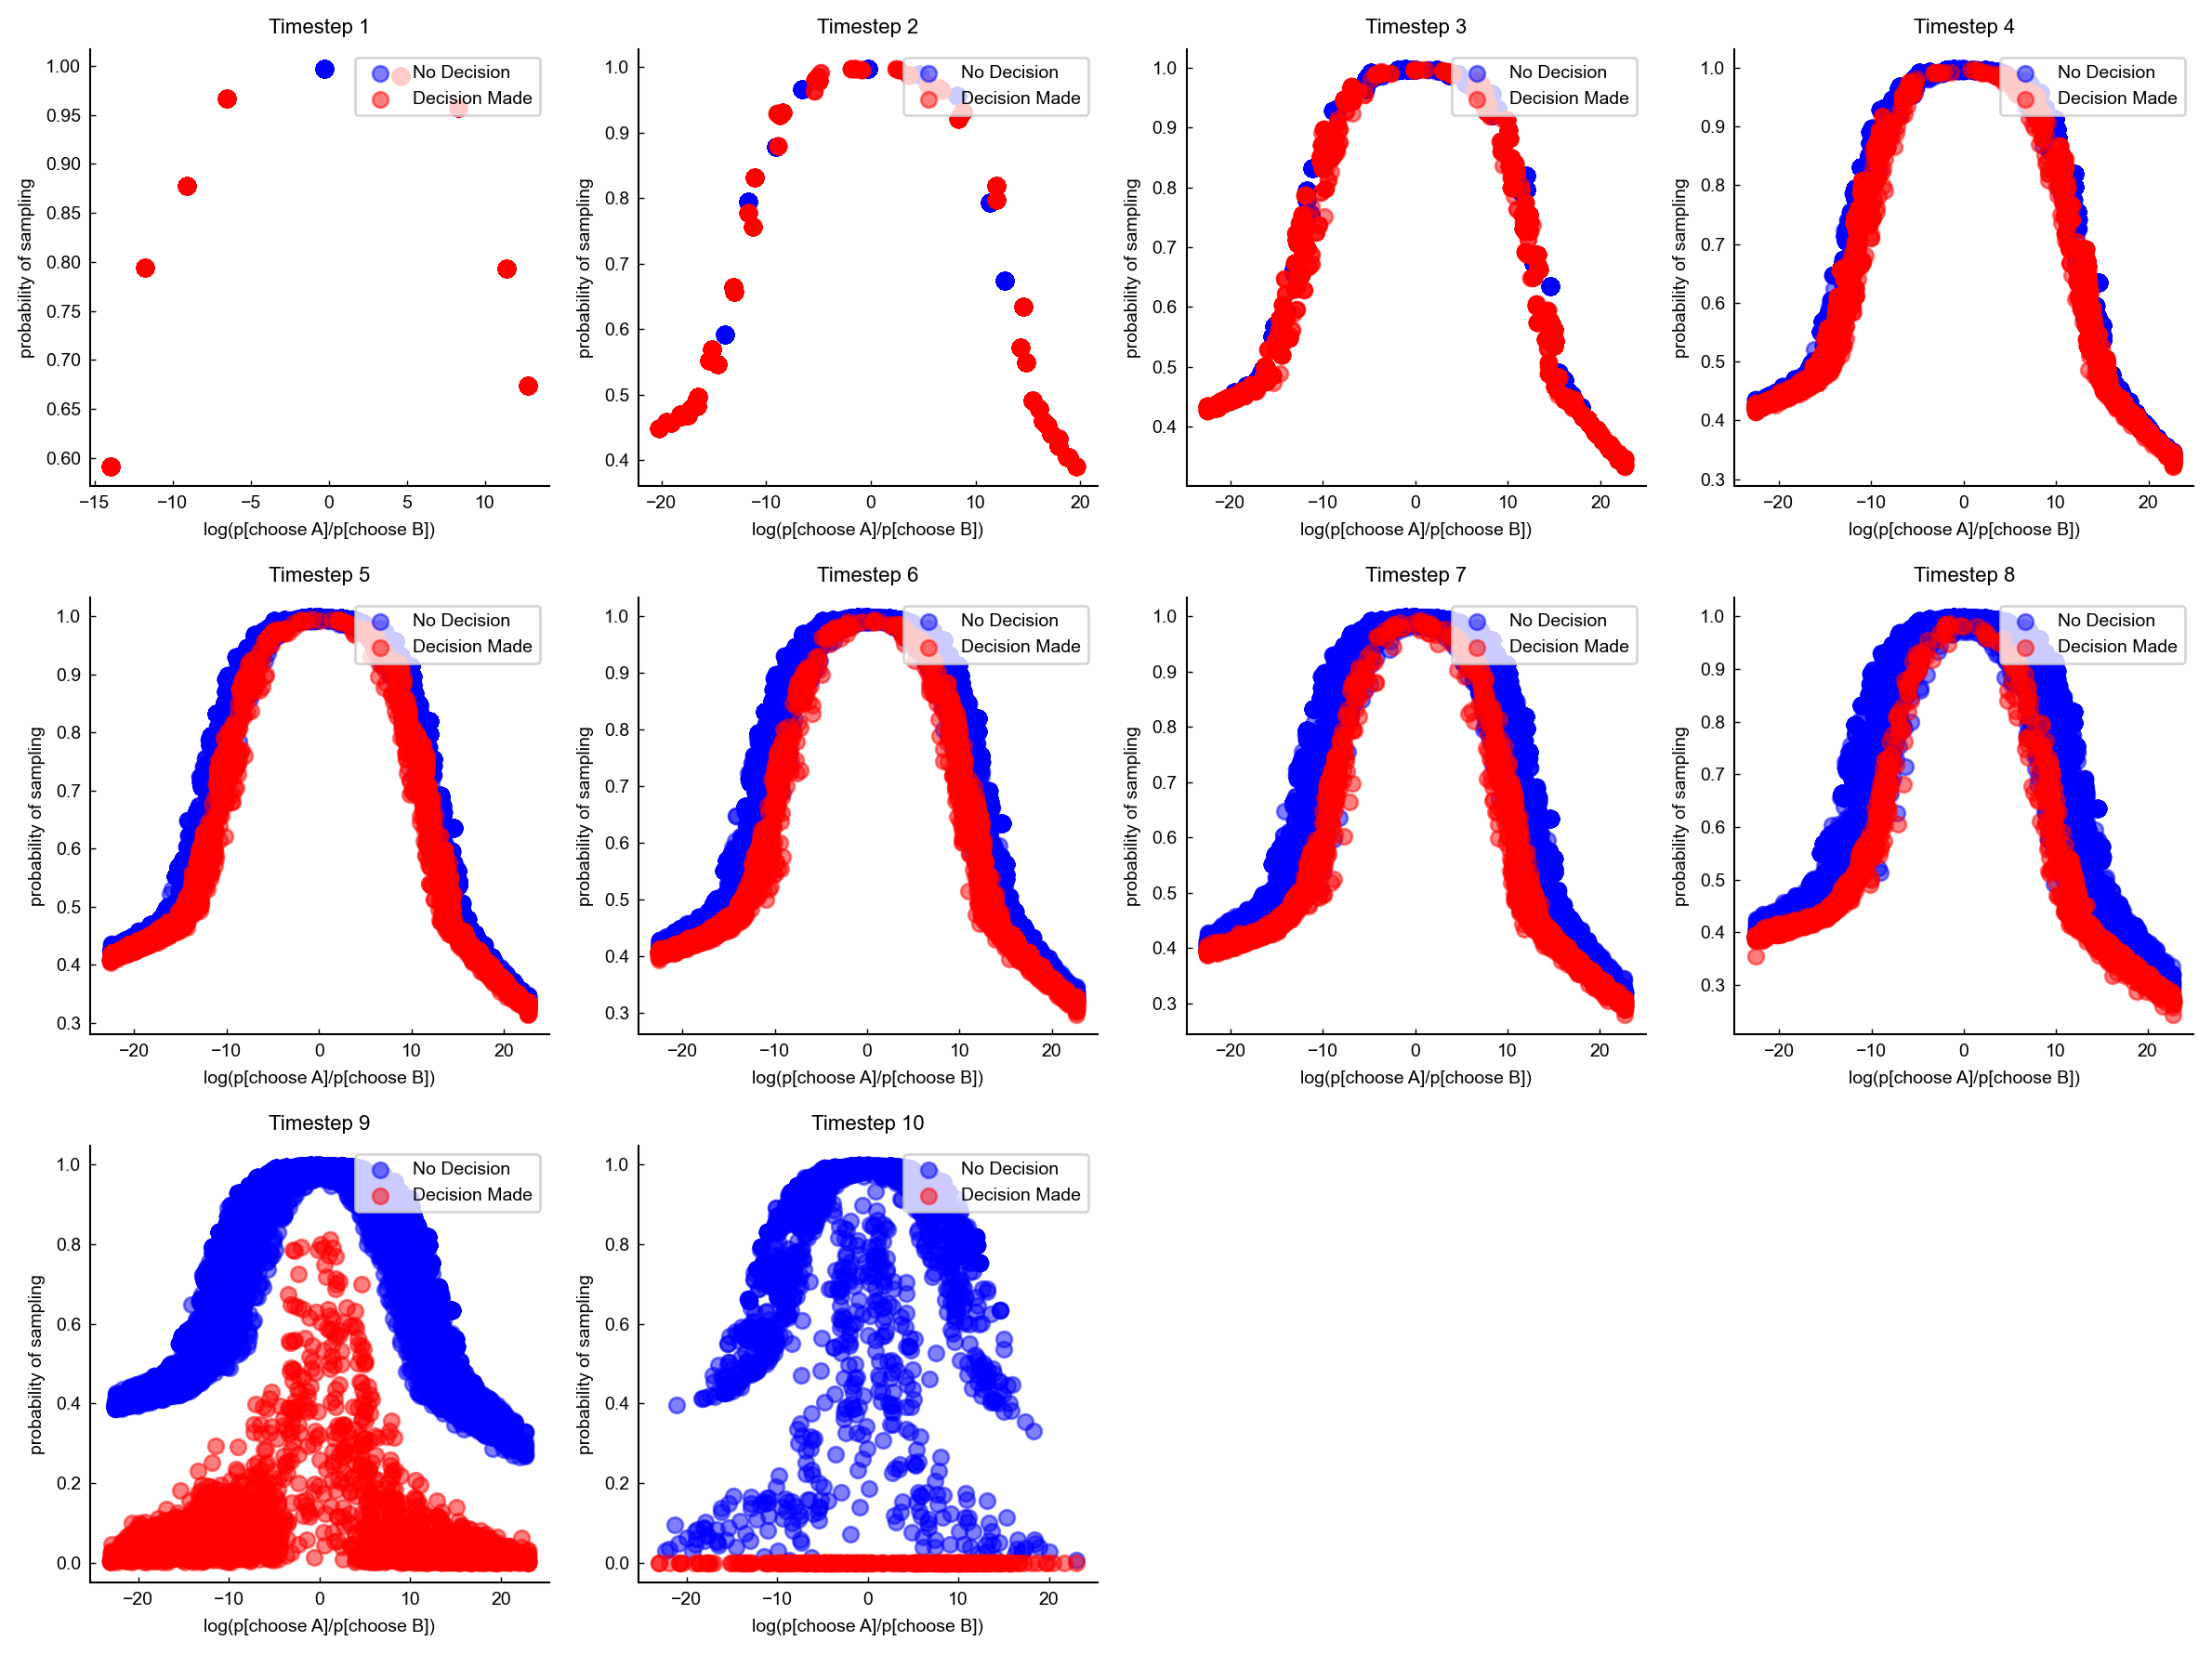

In [334]:
max_timestep = 10
n_rows = int(np.ceil(max_timestep/4))
fig, axes = plt.subplots(n_rows, 4, figsize=(12, 3*n_rows))
axes = axes.flatten()

# Plot scatter for each timestep
for t in range(max_timestep):
    if t < len(axes):
        # Get data for this timestep
        mask = df['decision_time'] == t+1
        timestep_data = df[mask]

        print(np.shape(timestep_data))
        
        # Create decision mask
        decision_mask = timestep_data['action'] < 2
        
        # Plot scatter points
        axes[t].scatter(timestep_data[~decision_mask]['log_ratio'], 
                       timestep_data[~decision_mask]['p_sample'],
                       c='blue', alpha=0.5, label='No Decision')
        axes[t].scatter(timestep_data[decision_mask]['log_ratio'],
                       timestep_data[decision_mask]['p_sample'], 
                       c='red', alpha=0.5, label='Decision Made')
        
        axes[t].set_title(f'Timestep {t + 1}')
        axes[t].set_xlabel('log(p[choose A]/p[choose B])')
        axes[t].set_ylabel('probability of sampling')
        axes[t].legend()

# Remove empty subplots
for i in range(max_timestep, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

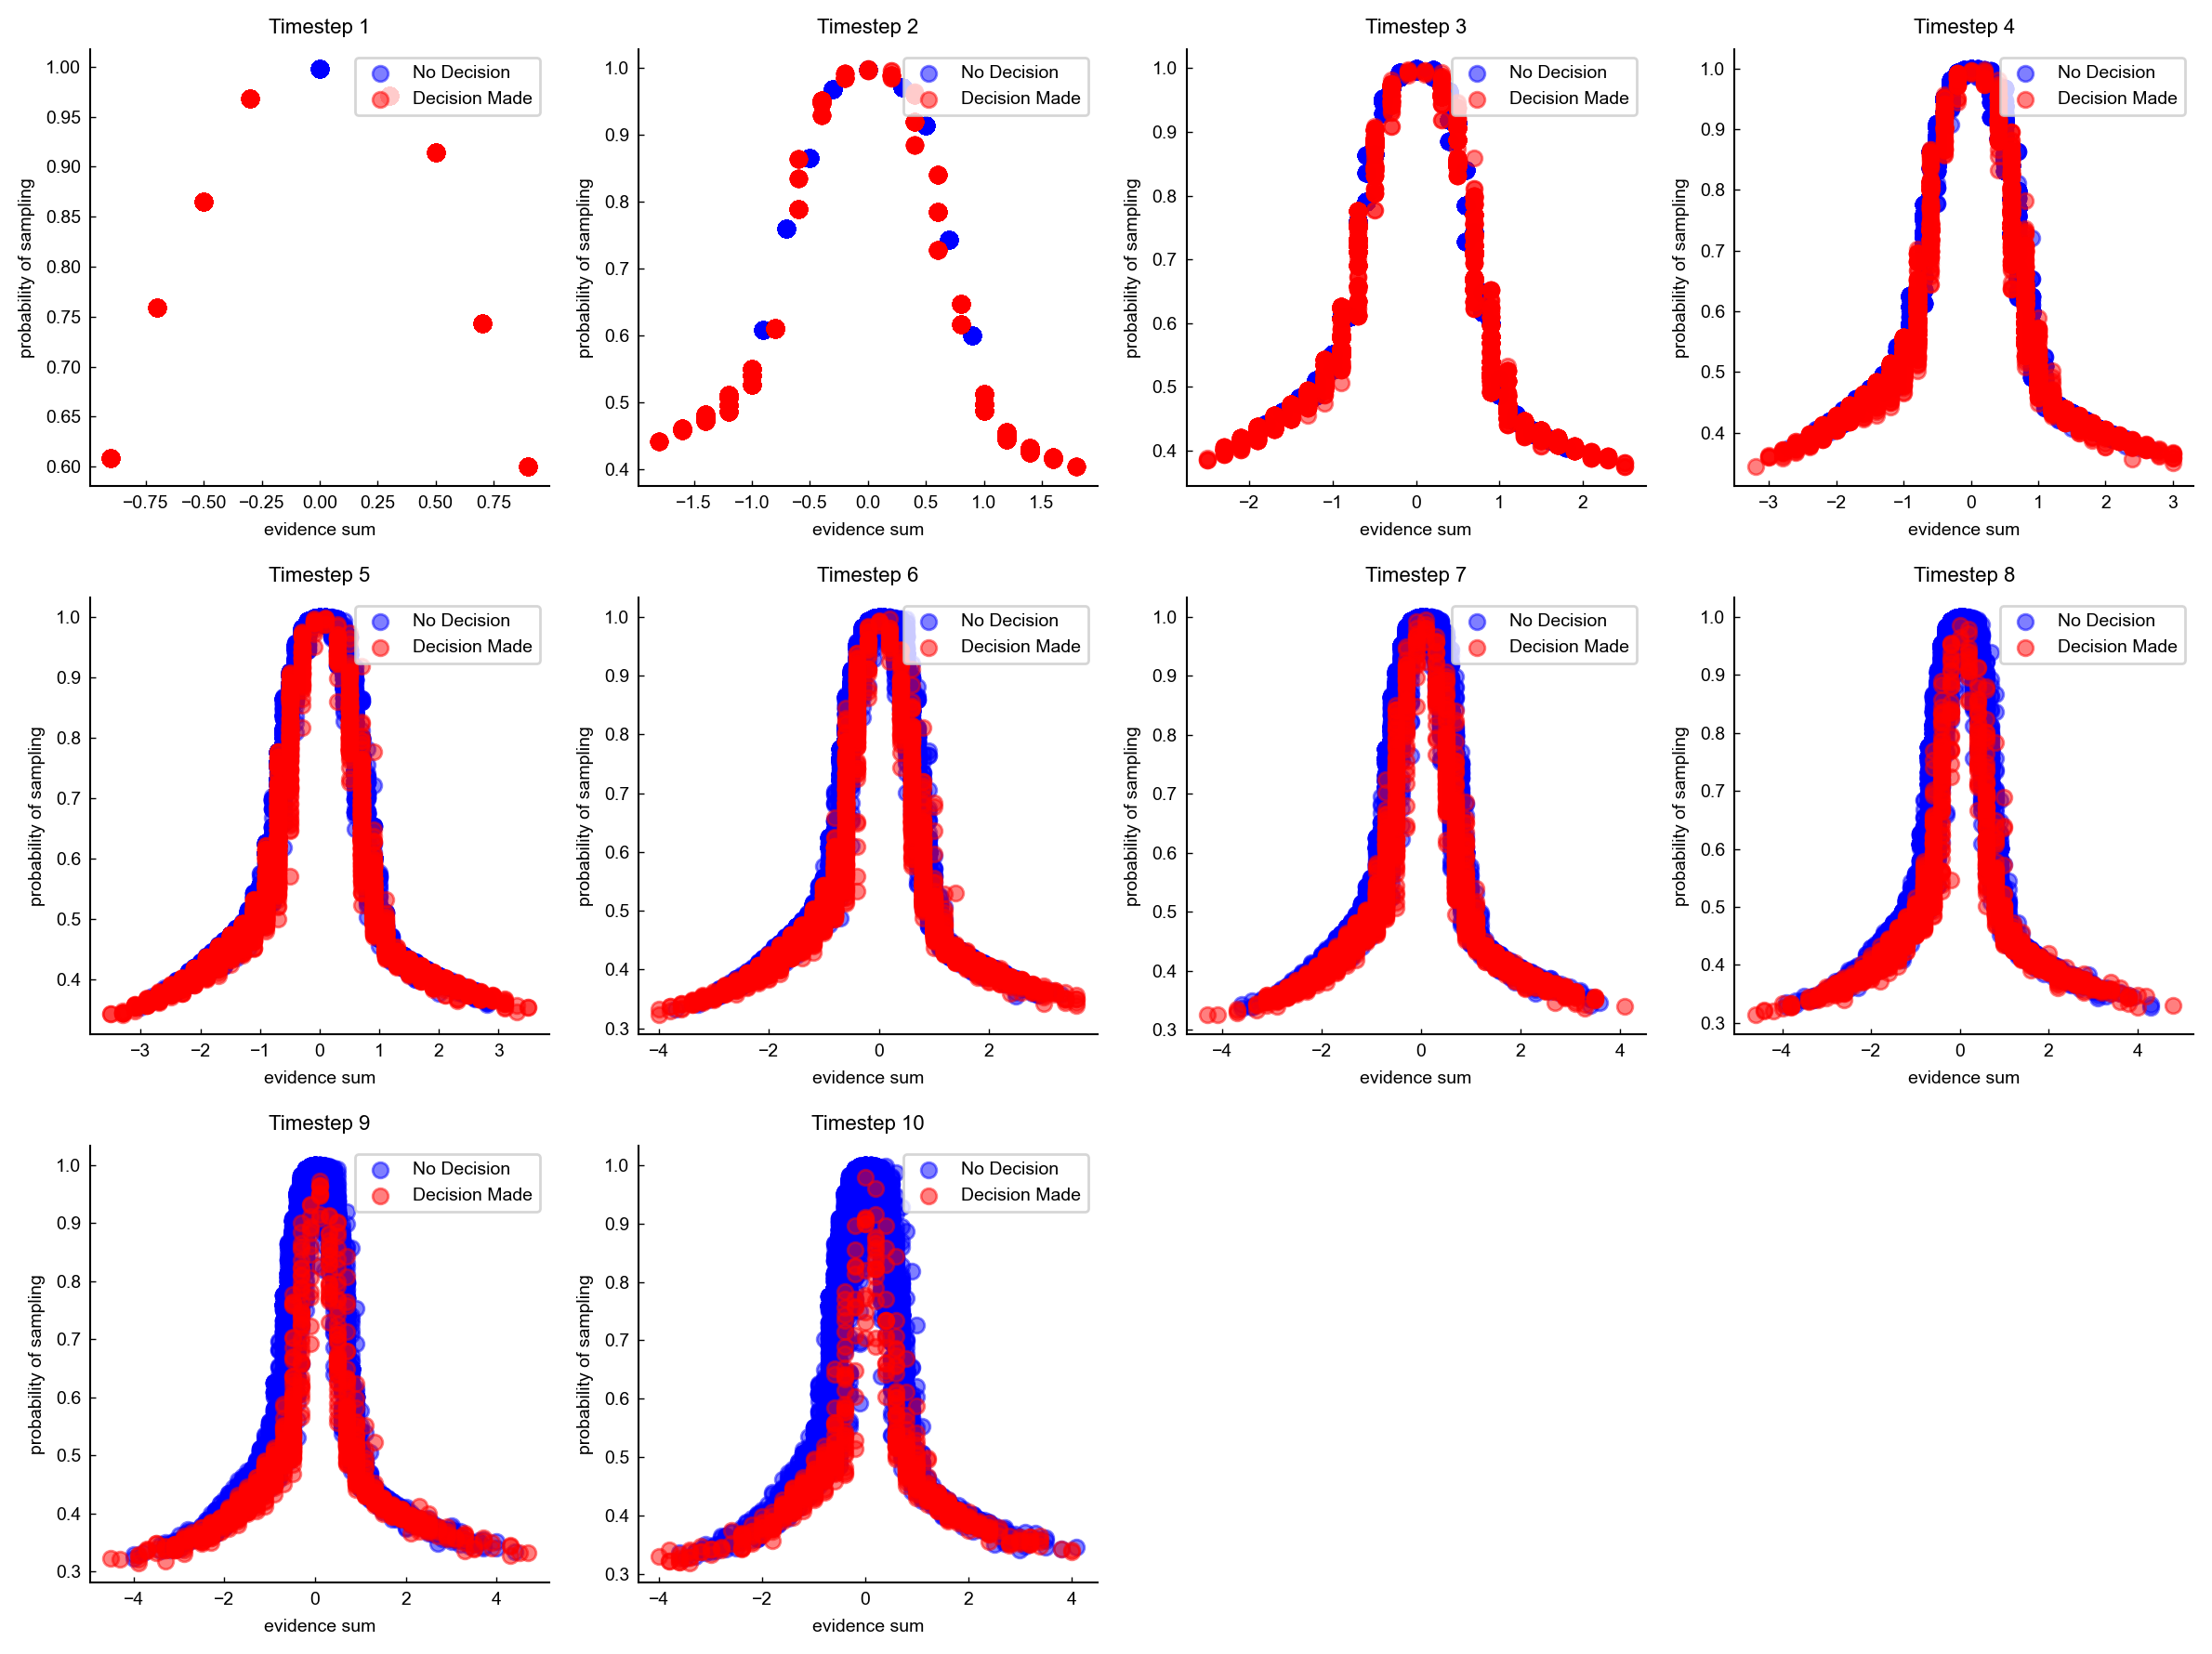

In [ ]:
max_timestep = 10
n_rows = int(np.ceil(max_timestep/4))
fig, axes = plt.subplots(n_rows, 4, figsize=(12, 3*n_rows))
axes = axes.flatten()

df["evidences"] = df.apply(lambda row: [target_log_ratios[s] for s in row["stimuli_so_far"][:row["decision_time"]]], axis=1)
df["evidence_sum"] = df["evidences"].apply(sum)

# Plot scatter for each timestep
for t in range(max_timestep):
    if t < len(axes):
        # Get data for this timestep
        mask = df['decision_time'] == t+1
        timestep_data = df[mask]
        
        # Create decision mask
        decision_mask = timestep_data['action'] < 2
        
        # Plot scatter points
        axes[t].scatter(timestep_data[~decision_mask]['evidence_sum'], 
                       timestep_data[~decision_mask]['p_sample'],
                       c='blue', alpha=0.5, label='No Decision')
        axes[t].scatter(timestep_data[decision_mask]['evidence_sum'],
                       timestep_data[decision_mask]['p_sample'], 
                       c='red', alpha=0.5, label='Decision Made')
        
        axes[t].set_title(f'Timestep {t+1}')
        axes[t].set_xlabel('evidence sum')
        axes[t].set_ylabel('probability of sampling')
        axes[t].legend()

# Remove empty subplots
for i in range(max_timestep, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



In [89]:
df_decision

,episode,correct_answer,stimuli_so_far,current_stimulus,action,reward,policy,hidden_state,decision_time,time_step,evidences,evidence_sum,p_chooseA,p_chooseB,p_sample,log_ratio,evidence_sum_bin
4,0,0,"[4, 7, 1, 5]",5,1,0.0,"[4.2960000000000004e-07, 0.5043537617, 0.49564...","[-0.27721768620000004, -0.0151891708, 0.159430...",4,4,"[0.3, 0.9, -0.7, 0.5]",1.0,4.296000e-07,5.043538e-01,0.495646,-6.069671,"(0.9, 1.0]"
14,2,1,"[3, 4, 6, 4]",4,1,1.0,"[2.8e-07, 0.5190169215, 0.4809827209]","[-0.11951613430000001, -0.0832366943, 0.066301...",4,4,"[-0.3, 0.3, 0.7, 0.3]",1.0,2.800000e-07,5.190169e-01,0.480983,-6.268023,"(0.9, 1.0]"
18,3,0,"[1, 4, 3]",3,0,1.0,"[0.3091818094, 3.5270000000000003e-07, 0.69081...","[0.1230927408, 0.1400399804, -0.21474885940000...",3,3,"[-0.7, 0.3, -0.3]",-0.7,3.091818e-01,3.527000e-07,0.690818,5.942808,"(-0.8, -0.7]"
26,4,0,"[3, 4, 3, 4, 2, 2, 6]",6,0,1.0,"[0.05065023900000001, 3.0289400000000002e-05, ...","[-0.019162453700000002, 0.1736865491, -0.25879...",7,7,"[-0.3, 0.3, -0.3, 0.3, -0.5, -0.5, 0.7]",-0.3,5.065024e-02,3.028940e-05,0.949319,3.223291,"(-0.4, -0.3]"
29,5,0,"[3, 2]",2,0,1.0,"[0.3880926371, 4.2050000000000004e-07, 0.61190...","[0.10556574170000001, 0.1271774173, -0.2240992...",2,2,"[-0.3, -0.5]",-0.8,3.880926e-01,4.205000e-07,0.611907,5.965169,"(-0.9, -0.8]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245766,49994,1,"[5, 4, 4]",4,1,1.0,"[1.523e-07, 0.5340584517, 0.46594136950000004]","[-0.1262246668, -0.0805340558, 0.1419456452, 0...",3,3,"[0.5, 0.3, 0.3]",1.1,1.523000e-07,5.340585e-01,0.465941,-6.544889,"(1.0, 1.1]"
245772,49995,0,"[4, 2, 3, 5, 0]",0,0,1.0,"[0.4414945543, 1.825e-07, 0.5585052967]","[0.0003668852, 0.19798503820000002, -0.2477577...",5,5,"[0.3, -0.5, -0.3, 0.5, -0.9]",-0.9,4.414946e-01,1.825000e-07,0.558505,6.383662,"(-1.0, -0.9]"
245784,49997,1,"[4, 3, 4, 6]",6,1,1.0,"[1.737e-07, 0.5208741426, 0.4791257083]","[-0.0990712494, -0.1415936351, 0.0238223299, 0...",4,4,"[0.3, -0.3, 0.3, 0.7]",1.0,1.737000e-07,5.208741e-01,0.479126,-6.476933,"(0.9, 1.0]"
245787,49998,1,"[4, 6]",6,1,1.0,"[1.483e-07, 0.5020438433000001, 0.4979560673]","[-0.023090645700000002, -0.13894361260000002, ...",2,2,"[0.3, 0.7]",1.0,1.483000e-07,5.020438e-01,0.497956,-6.529600,"(0.9, 1.0]"


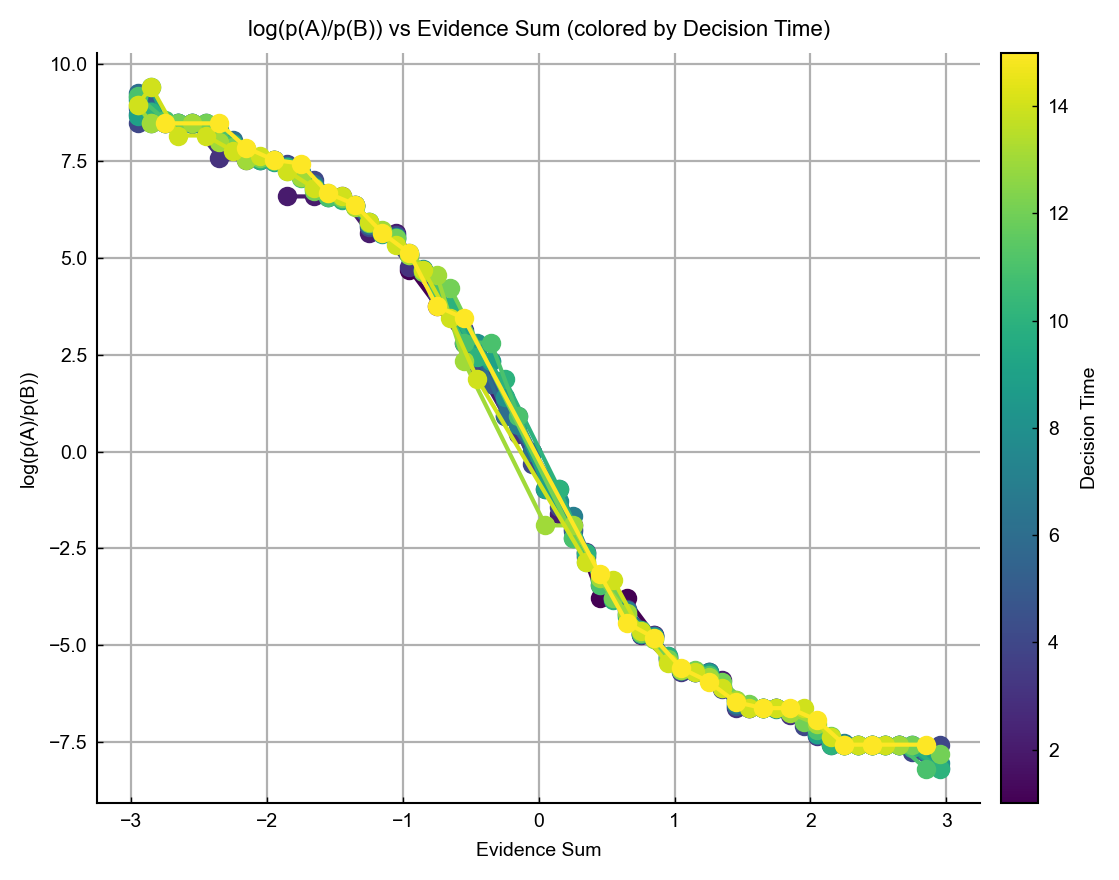

In [128]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

df_decision = df_decision[~df_decision['log_ratio'].isin([np.inf, -np.inf, np.nan])]

# 1. 定义 bins 数量并生成边界
n_bins = 20
bin_edges = np.linspace(df_decision['log_ratio'].min(), df_decision['log_ratio'].max(), n_bins + 1)

# 2. 分箱并计算平均采样概率
df_decision['log_ratio_bin'] = pd.cut(df_decision['log_ratio'], bins=bin_edges, include_lowest=True)


# 1. Compute the bin centers
df_decision['evidence_center'] = df_decision['evidence_sum_bin'].apply(lambda x: (x.left + x.right) / 2 if pd.notnull(x) else np.nan).astype(float)
df_decision['log_ratio_center'] = df_decision['log_ratio_bin'].apply(lambda x: (x.left + x.right) / 2 if pd.notnull(x) else np.nan).astype(float)

# 2. Drop rows with missing bin centers
df_plot = df_decision.dropna(subset=['evidence_center', 'log_ratio_center', 'decision_time'])

# 3. Get unique decision times
decision_times = sorted(df_plot['decision_time'].unique())

# # 4. Plot: One subplot per decision time
# ncols = 4
# nrows = int(np.ceil(len(decision_times) / ncols))

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3*nrows), sharex=True, sharey=True)

# for i, dt in enumerate(decision_times):
#     ax = axes.flat[i]
#     subset = df_plot[df_plot['decision_time'] == dt]
    
#     # Group by evidence bins and compute mean log-ratio
#     grouped = subset.groupby('evidence_center')['log_ratio_center'].mean().reset_index()
    
#     ax.plot(grouped['evidence_center'], grouped['log_ratio_center'], marker='o', label=f'dt={dt}')
#     ax.set_title(f'Decision Time: {dt}')
#     ax.set_xlabel('Evidence Sum')
#     ax.set_ylabel('log(p(A)/p(B))')

# # Hide unused subplots
# for j in range(len(decision_times), len(axes.flat)):
#     fig.delaxes(axes.flat[j])

# plt.tight_layout()
# plt.suptitle("log(p(A)/p(B)) vs Evidence Sum (by Decision Time)", fontsize=14, y=1.02)
# plt.show()

# 颜色映射配置
cmap = cm.viridis
norm = Normalize(vmin=1, vmax=15)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# 创建单个图
fig, ax = plt.subplots(figsize=(6, 4.5))

for dt in decision_times:

    if dt > 15:
        break
    subset = df_plot[df_plot['decision_time'] == dt]
    
    # Group by evidence bins and compute mean log-ratio
    grouped = subset.groupby('evidence_center')['log_ratio_center'].mean().reset_index()
    
    ax.plot(grouped['evidence_center'],
            grouped['log_ratio_center'],
            marker='o',
            color=cmap(norm(dt)),
            label=f'dt={dt}')

# 图形美化
ax.set_xlabel('Evidence Sum')
ax.set_ylabel('log(p(A)/p(B))')
ax.set_title("log(p(A)/p(B)) vs Evidence Sum (colored by Decision Time)")
ax.grid(True)

# 添加颜色条（colorbar）
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('Decision Time')

# 可选：添加图例（若太拥挤建议不加）
# ax.legend(title='Decision Time', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

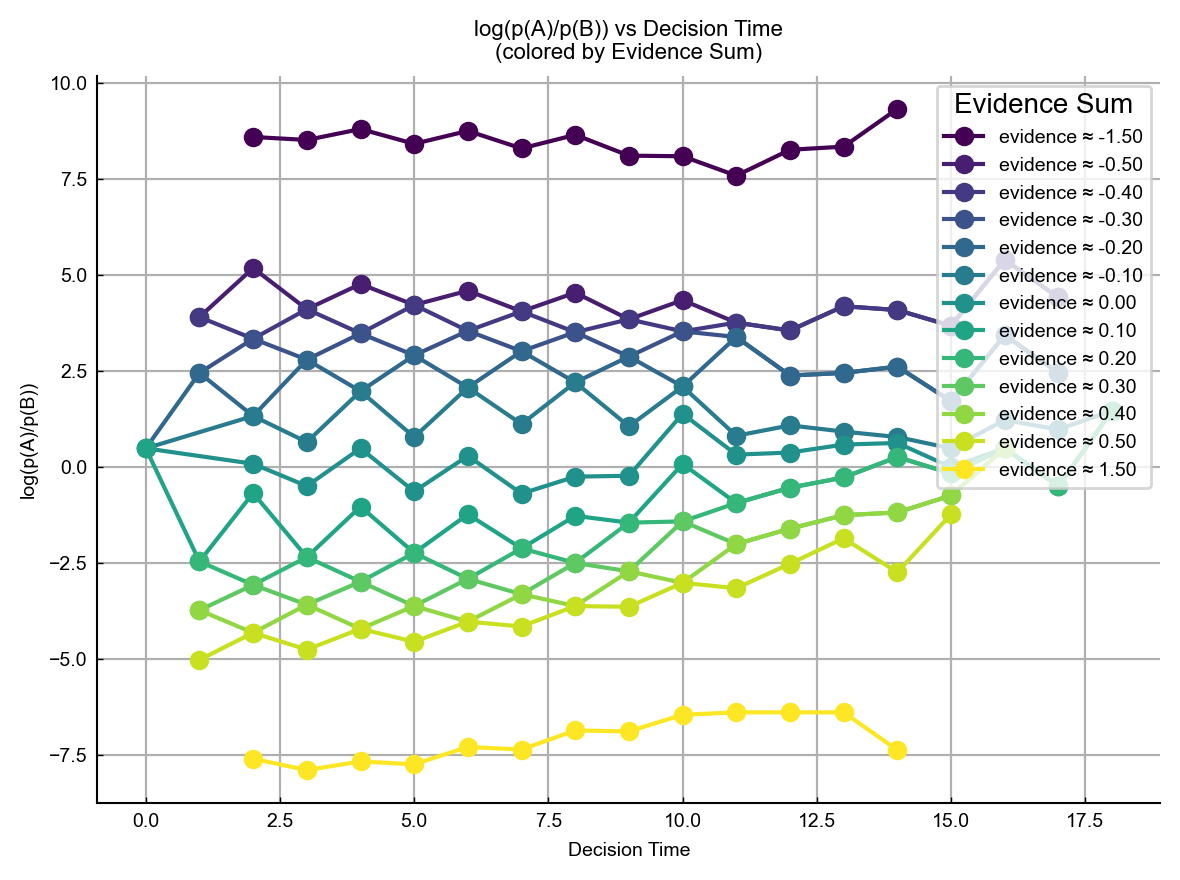

In [99]:
# 选定的 evidence center 水平（你可以按需修改）
selected_evidence_centers = [-1.5, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.5]

# 颜色映射设置（为了分辨不同 evidence_sum）
colors = cm.viridis(np.linspace(0, 1, len(selected_evidence_centers)))

# 创建图
fig, ax = plt.subplots(figsize=(6, 4.5))

for i, ec in enumerate(selected_evidence_centers):
    # 提取当前 evidence_center 附近的数据（允许一点浮动误差）
    subset = df_plot[np.isclose(df_plot['evidence_center'], ec, atol=0.15)]

    # 分组并计算每个 decision_time 对应的 log_ratio_center 均值
    grouped = subset.groupby('decision_time')['log_ratio_center'].mean().reset_index()

    ax.plot(grouped['decision_time'],
            grouped['log_ratio_center'],
            marker='o',
            color=colors[i],
            label=f'evidence ≈ {ec:.2f}')

# 图形美化
ax.set_xlabel('Decision Time')
ax.set_ylabel('log(p(A)/p(B))')
ax.set_title('log(p(A)/p(B)) vs Decision Time\n(colored by Evidence Sum)')
ax.grid(True)
ax.legend(title='Evidence Sum')

plt.tight_layout()
plt.show()

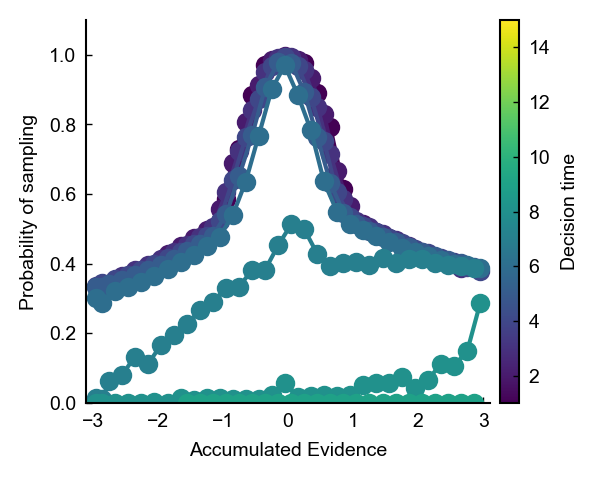

In [69]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

bin_width = 0.1
bin_start = -3
bin_end = 3.1

# only keep the rows that action is equal to correct_answer
df_decision = df_decision[df_decision['action'] == df_decision['correct_answer']]

df_decision["evidence_sum_bin"] = pd.cut(
    df_decision["evidence_sum"], 
    bins=np.arange(bin_start, bin_end, bin_width), 
    include_lowest=True
)


# n_bins = 33
# bin_edges = np.linspace(df['evidence_sum'].min(), df['evidence_sum'].max(), n_bins + 1)

# 2. 分箱并计算平均采样概率
# df['evidence_sum_bin'] = pd.cut(df['evidence_sum'], bins=bin_edges, include_lowest=True)
df_binned = (
    df_decision.dropna(subset=['evidence_sum_bin'])
      .groupby(['decision_time', 'evidence_sum_bin'], observed=True)['p_sample']
      .mean()
      .reset_index()
)
df_binned['bin_center'] = df_binned['evidence_sum_bin'].apply(lambda iv: iv.mid)

# 3. 配置 colormap
# dt_values = sorted(df_binned['decision_time'].unique())
dt_values = np.arange(1, 16)
cmap = cm.viridis
norm = Normalize(vmin=min(dt_values), vmax=max(dt_values))
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

df_binned['bin_center'] = df_binned['evidence_sum_bin'].apply(lambda iv: (iv.left + iv.right) / 2).astype(float)
df_binned = df_binned[df_binned['bin_center'].between(-3, 3)]
# df_binned = df_binned[df_binned['decision_time'] <= 15]

# 4. 绘图
fig, ax = plt.subplots(figsize=(3.10, 2.5))
for dt in dt_values:

    subset = df_binned[df_binned['decision_time'] == dt]
    ax.plot(subset['bin_center'],
            subset['p_sample'],
            marker='o',
            color=cmap(norm(dt)),
            label=f'dt={dt}')

ax.set_xlabel('Accumulated Evidence')
ax.set_ylabel('Probability of sampling')
# ax.set_title('Sampling Probability vs Cumulative Evidence by Decision Time')
ax.grid(False)
ax.set_xlim(-3.1, 3.1)
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(-3, 4, 1))
# ax.set_aspect('equal', adjustable='box')

# 5. 添加 colorbar，指定 ax
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('Decision time')

# ax.legend(title='decision_time', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# plt.savefig('sampling_probability_vs_evidence_sum_softBound.svg', dpi=300)
plt.show()

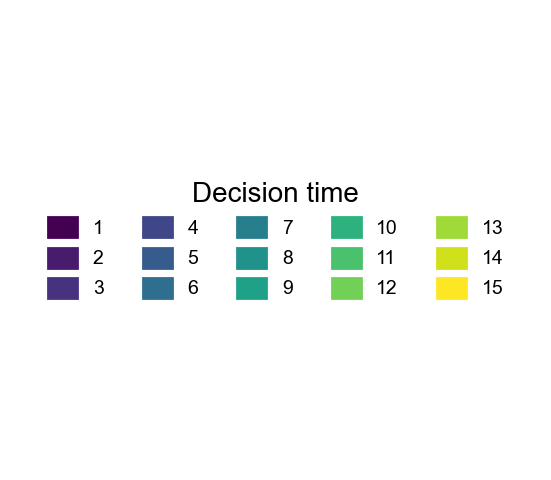

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import Normalize


# 决策时间值
dt_values = np.arange(1, 16)

# 设置 colormap 和归一化器
cmap = cm.viridis
norm = Normalize(vmin=min(dt_values), vmax=max(dt_values))

# 为每个 dt 创建一个 color patch
patches = [
    mpatches.Patch(color=cmap(norm(dt)), label=f'{dt}')
    for dt in dt_values
]

# 单独创建 legend 图
fig, ax = plt.subplots(figsize=(3, 2.5))
ax.axis('off')  # 不显示坐标轴

# 添加 legend，设置每行最多显示的标签数
legend = ax.legend(
    handles=patches,
    title='Decision time',
    loc='center',
    ncol=5,  # 每行 5 个标签，可调整
    frameon=False,
    handlelength=1.5,
    handleheight=1.2,
    borderpad=1.0
)

plt.tight_layout()
plt.savefig('legend_decision_time_discrete.svg', dpi=300)
plt.show()

In [74]:
df_binned[df_binned['decision_time'] == 1]

,decision_time,evidence_sum_bin,p_sample,bin_center
1,1,"(-1.0, -0.9]",0.608325,-0.95
2,1,"(-0.8, -0.7]",0.759593,-0.75
3,1,"(-0.6, -0.5]",0.865494,-0.55
4,1,"(-0.4, -0.3]",0.968625,-0.35
5,1,"(0.2, 0.3]",0.971289,0.25
6,1,"(0.4, 0.5]",0.914302,0.45
7,1,"(0.6, 0.7]",0.743285,0.65
8,1,"(0.8, 0.9]",0.600427,0.85


In [105]:
print(sorted(df_binned['bin_center'].unique()))

[np.float64(-2.9505), np.float64(-2.8499999999999996), np.float64(-2.75), np.float64(-2.6500000000000004), np.float64(-2.55), np.float64(-2.45), np.float64(-2.3499999999999996), np.float64(-2.25), np.float64(-2.1500000000000004), np.float64(-2.05), np.float64(-1.95), np.float64(-1.85), np.float64(-1.75), np.float64(-1.65), np.float64(-1.55), np.float64(-1.45), np.float64(-1.35), np.float64(-1.25), np.float64(-1.15), np.float64(-1.05), np.float64(-0.95), np.float64(-0.8500000000000001), np.float64(-0.75), np.float64(-0.6499999999999999), np.float64(-0.55), np.float64(-0.45), np.float64(-0.35), np.float64(-0.25), np.float64(-0.15000000000000002), np.float64(-0.04999999999999867), np.float64(0.050000000000001335), np.float64(0.15000000000000002), np.float64(0.25), np.float64(0.35), np.float64(0.45), np.float64(0.55), np.float64(0.6499999999999999), np.float64(0.75), np.float64(0.8500000000000001), np.float64(0.95), np.float64(1.05), np.float64(1.15), np.float64(1.25), np.float64(1.35), np

/var/folders/j5/y5g6mhcd7wg0lg4_wsdrql7r0000gn/T/ipykernel_2229/1961750374.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_legend.legend(title='Accumulated Evidence', loc='best')


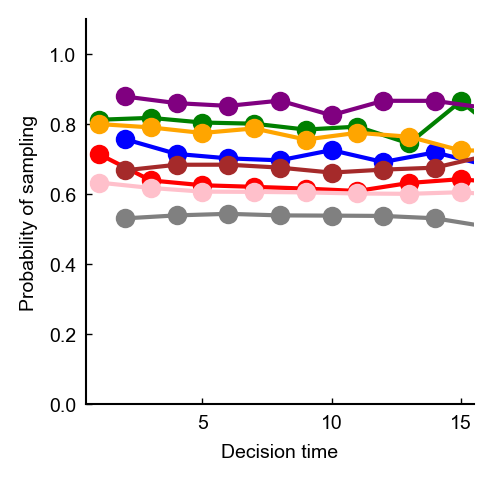

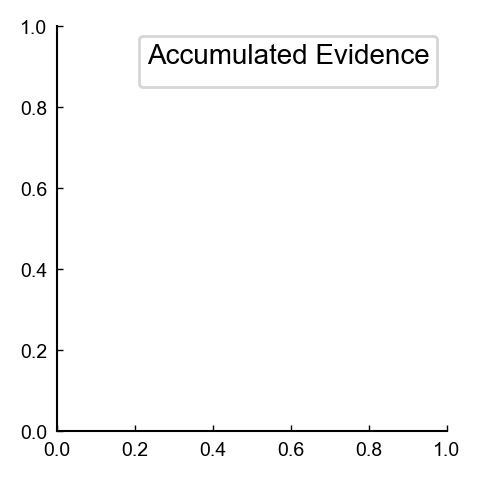

In [34]:
# ---------- Step 1: 选择中心在特定值附近的 evidence bin ----------
target_evidence_vals = [-0.95, -0.85, -0.75,0.55, 0.65, 0.75, 0.85, 0.95]
# target_evidence_vals = [-0.95, -0.85, -0.75, -0.65]
tolerance = 0.05  # 允许的 bin_center 偏差

# 为每个目标 evidence 值找到最近的 bin_center 值
selected_bins = []
for target in target_evidence_vals:
    closest = df_binned.loc[np.abs(df_binned['bin_center'] - target).idxmin(), 'bin_center']
    selected_bins.append(closest)

# ---------- Step 2: 筛选数据 ----------
df_selected = df_binned[df_binned['bin_center'].isin(selected_bins)].copy()

# ---------- Step 3: 准备绘图 ----------
# 横轴为 decision_time，纵轴为 p_sample，不同颜色表示不同 evidence bin
# colors = plt.get_cmap("tab10").colors[:len(selected_bins)]  # 使用 tab10 colormap
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'yellow', 'cyan', 'magenta']
color_map = dict(zip(selected_bins, colors))

fig, ax = plt.subplots(figsize=(2.5, 2.5))

for bin_center in selected_bins:
    subset = df_selected[df_selected['bin_center'] == bin_center]
    ax.plot(subset['decision_time'],
            subset['p_sample'],
            marker='o',
            color=color_map[bin_center],
            label=f'Evidence ≈ {bin_center:.2f}')

# ---------- Step 4: 美化 ----------
ax.set_xlabel('Decision time')
ax.set_ylabel('Probability of sampling')
ax.set_xticks(np.arange(0, 16, 5))
ax.set_xlim(0.5, 15.5)
ax.set_ylim(0, 1.1)
# ax.set_ylim(0.5, 1.1)
ax.grid(False)
# ax.legend(title='Accumulated Evidence', loc='best')


# plt.tight_layout()
# plt.savefig('sampling_probability_vs_time_colored_by_evidence.svg', dpi=300)
# plt.show()

# plot the legend in the separate figure
fig_legend, ax_legend = plt.subplots(figsize=(2.5, 2.5))
ax_legend.legend(title='Accumulated Evidence', loc='best')
plt.tight_layout()
plt.show()

In [35]:
df

,episode,correct_answer,stimuli_so_far,current_stimulus,action,reward,policy,hidden_state,decision_time,time_step,evidences,evidence_sum,p_chooseA,p_chooseB,p_sample,log_ratio,evidence_sum_bin,evidence_sum_binned
0,0,0,[],-1,2,-0.01,"[0.001378927, 0.0018724786, 0.9967485666]","[0.0039211409, -0.0282283425, 0.2018316537, 0....",4,0,[],0.0,1.378927e-03,1.872479e-03,0.996749,-0.132876,"(-0.0939, 0.194]",0.005
1,0,0,[4],4,2,-0.01,"[4.81162e-05, 0.033836208300000004, 0.9661157131]","[-0.0325882584, 0.0657552481, 0.2276824564, 0....",4,1,[0.3],0.3,4.811620e-05,3.383621e-02,0.966116,-2.847090,"(0.194, 0.482]",0.305
2,0,0,"[4, 7]",7,2,-0.01,"[3.2900000000000003e-08, 0.5181847811, 0.48181...","[-0.14296673240000002, 0.16567960380000002, 0....",4,2,"[0.3, 0.9]",1.2,3.290000e-08,5.181848e-01,0.481815,-7.197289,"(1.058, 1.345]",1.205
3,0,0,"[4, 7, 1]",1,2,-0.01,"[2.12005e-05, 0.1458586752, 0.8541200757]","[-0.06825251880000001, -0.019068390100000002, ...",4,3,"[0.3, 0.9, -0.7]",0.5,2.120050e-05,1.458587e-01,0.854120,-3.837586,"(0.482, 0.77]",0.505
4,0,0,"[4, 7, 1, 5]",5,1,0.00,"[3.89e-07, 0.5100229383, 0.48997676370000004]","[-0.1097732335, 0.07974112030000001, 0.1958144...",4,4,"[0.3, 0.9, -0.7, 0.5]",1.0,3.890000e-07,5.100229e-01,0.489977,-6.117640,"(0.77, 1.058]",1.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254986,49999,1,"[3, 3]",3,2,-0.01,"[0.0681240037, 1.01153e-05, 0.9318658710000001]","[0.0835145563, -0.0711762011, 0.26783257720000...",6,2,"[-0.3, -0.3]",-0.6,6.812400e-02,1.011530e-05,0.931866,3.828321,"(-0.67, -0.382]",-0.595
254987,49999,1,"[3, 3, 3]",3,2,-0.01,"[0.245855391, 1.1180000000000001e-06, 0.754143...","[0.1135102808, -0.096988447, 0.247840002200000...",6,3,"[-0.3, -0.3, -0.3]",-0.9,2.458554e-01,1.118000e-06,0.754143,5.342238,"(-0.958, -0.67]",-0.895
254988,49999,1,"[3, 3, 3, 5]",5,2,-0.01,"[0.017925435700000002, 0.0002092216, 0.9818653...","[0.0505790636, -0.043201446500000004, 0.206901...",6,4,"[-0.3, -0.3, -0.3, 0.5]",-0.4,1.792544e-02,2.092216e-04,0.981865,1.932863,"(-0.67, -0.382]",-0.395
254989,49999,1,"[3, 3, 3, 5, 3]",3,2,-0.01,"[0.1241209954, 2.61752e-05, 0.8758527637]","[0.08355197310000001, -0.0899255127, 0.1189577...",6,5,"[-0.3, -0.3, -0.3, 0.5, -0.3]",-0.7,1.241210e-01,2.617520e-05,0.875853,3.675955,"(-0.958, -0.67]",-0.695


In [38]:
df_plot

,episode,correct_answer,stimuli_so_far,current_stimulus,action,reward,policy,hidden_state,decision_time,time_step,evidences,evidence_sum,p_chooseA,p_chooseB,p_sample,log_ratio,evidence_sum_bin,evidence_sum_binned,log_bin
0,0,0,[],-1,2,-0.01,"[0.001378927, 0.0018724786, 0.9967485666]","[0.0039211409, -0.0282283425, 0.2018316537, 0....",4,0,[],0.0,1.378927e-03,1.872479e-03,0.996749,-0.132876,"(-0.0939, 0.194]",0.005,"(-1.0, 0.0]"
1,0,0,[4],4,2,-0.01,"[4.81162e-05, 0.033836208300000004, 0.9661157131]","[-0.0325882584, 0.0657552481, 0.2276824564, 0....",4,1,[0.3],0.3,4.811620e-05,3.383621e-02,0.966116,-2.847090,"(0.194, 0.482]",0.305,"(-3.0, -2.0]"
2,0,0,"[4, 7]",7,2,-0.01,"[3.2900000000000003e-08, 0.5181847811, 0.48181...","[-0.14296673240000002, 0.16567960380000002, 0....",4,2,"[0.3, 0.9]",1.2,3.290000e-08,5.181848e-01,0.481815,-7.197289,"(1.058, 1.345]",1.205,"(-8.0, -7.0]"
3,0,0,"[4, 7, 1]",1,2,-0.01,"[2.12005e-05, 0.1458586752, 0.8541200757]","[-0.06825251880000001, -0.019068390100000002, ...",4,3,"[0.3, 0.9, -0.7]",0.5,2.120050e-05,1.458587e-01,0.854120,-3.837586,"(0.482, 0.77]",0.505,"(-4.0, -3.0]"
4,0,0,"[4, 7, 1, 5]",5,1,0.00,"[3.89e-07, 0.5100229383, 0.48997676370000004]","[-0.1097732335, 0.07974112030000001, 0.1958144...",4,4,"[0.3, 0.9, -0.7, 0.5]",1.0,3.890000e-07,5.100229e-01,0.489977,-6.117640,"(0.77, 1.058]",1.005,"(-7.0, -6.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254986,49999,1,"[3, 3]",3,2,-0.01,"[0.0681240037, 1.01153e-05, 0.9318658710000001]","[0.0835145563, -0.0711762011, 0.26783257720000...",6,2,"[-0.3, -0.3]",-0.6,6.812400e-02,1.011530e-05,0.931866,3.828321,"(-0.67, -0.382]",-0.595,"(3.0, 4.0]"
254987,49999,1,"[3, 3, 3]",3,2,-0.01,"[0.245855391, 1.1180000000000001e-06, 0.754143...","[0.1135102808, -0.096988447, 0.247840002200000...",6,3,"[-0.3, -0.3, -0.3]",-0.9,2.458554e-01,1.118000e-06,0.754143,5.342238,"(-0.958, -0.67]",-0.895,"(5.0, 6.0]"
254988,49999,1,"[3, 3, 3, 5]",5,2,-0.01,"[0.017925435700000002, 0.0002092216, 0.9818653...","[0.0505790636, -0.043201446500000004, 0.206901...",6,4,"[-0.3, -0.3, -0.3, 0.5]",-0.4,1.792544e-02,2.092216e-04,0.981865,1.932863,"(-0.67, -0.382]",-0.395,"(1.0, 2.0]"
254989,49999,1,"[3, 3, 3, 5, 3]",3,2,-0.01,"[0.1241209954, 2.61752e-05, 0.8758527637]","[0.08355197310000001, -0.0899255127, 0.1189577...",6,5,"[-0.3, -0.3, -0.3, 0.5, -0.3]",-0.7,1.241210e-01,2.617520e-05,0.875853,3.675955,"(-0.958, -0.67]",-0.695,"(3.0, 4.0]"


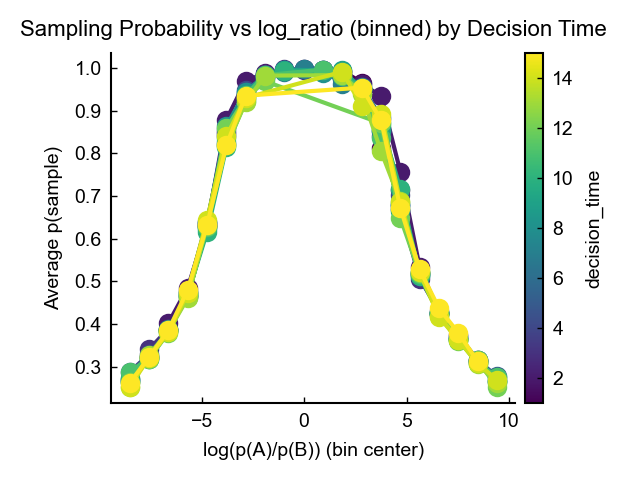

In [24]:
df_plot = df_decision.copy()

# remove the rows where log_ratio is inf or nan or -inf
df_plot = df_plot[~df_plot['log_ratio'].isin([np.inf, -np.inf, np.nan])]

# 1. 定义 bins 数量并生成边界
n_bins = 20
bin_edges = np.linspace(df_plot['log_ratio'].min(), df_plot['log_ratio'].max(), n_bins + 1)

# 2. 分箱并计算平均采样概率
df_plot['log_bin'] = pd.cut(df_plot['log_ratio'], bins=bin_edges, include_lowest=True)
df_binned = (
    df_plot.dropna(subset=['log_bin'])
      .groupby(['decision_time', 'log_bin'], observed=True)['p_sample']
      .mean()
      .reset_index()
)
df_binned['bin_center'] = df_binned['log_bin'].apply(lambda iv: iv.mid)

# 3. 配置 colormap
dt_values = sorted(df_binned['decision_time'].unique())
dt_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
cmap = cm.viridis
norm = Normalize(vmin=min(dt_values), vmax=max(dt_values))
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# 4. 绘图
fig, ax = plt.subplots(figsize=(3.10, 2.5))
for dt in dt_values:
    subset = df_binned[df_binned['decision_time'] == dt]
    ax.plot(subset['bin_center'],
            subset['p_sample'],
            marker='o',
            color=cmap(norm(dt)),
            label=f'dt={dt}')

ax.set_xlabel('log(p(A)/p(B)) (bin center)')
ax.set_ylabel('Average p(sample)')
ax.set_title('Sampling Probability vs log_ratio (binned) by Decision Time')
# ax.grid(True)

# 5. 添加 colorbar，指定 ax
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('decision_time')

# ax.legend(title='decision_time', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [85]:
df_binned[df_binned['decision_time'] == 4]

,decision_time,log_bin,p_sample,bin_center
46,4,"(-9.82, -8.837]",0.389392,-9.328500
47,4,"(-8.837, -7.854]",0.412087,-8.345500
48,4,"(-7.854, -6.872]",0.435622,-7.363000
49,4,"(-6.872, -5.89]",0.477866,-6.381000
50,4,"(-5.89, -4.908]",0.597005,-5.399000
51,4,"(-4.908, -3.925]",0.767321,-4.416500
52,4,"(-3.925, -2.943]",0.914233,-3.434000
53,4,"(-2.943, -1.961]",0.947262,-2.452000
54,4,"(-1.961, -0.979]",0.982344,-1.470000
55,4,"(-0.979, 0.00365]",0.995881,-0.487675


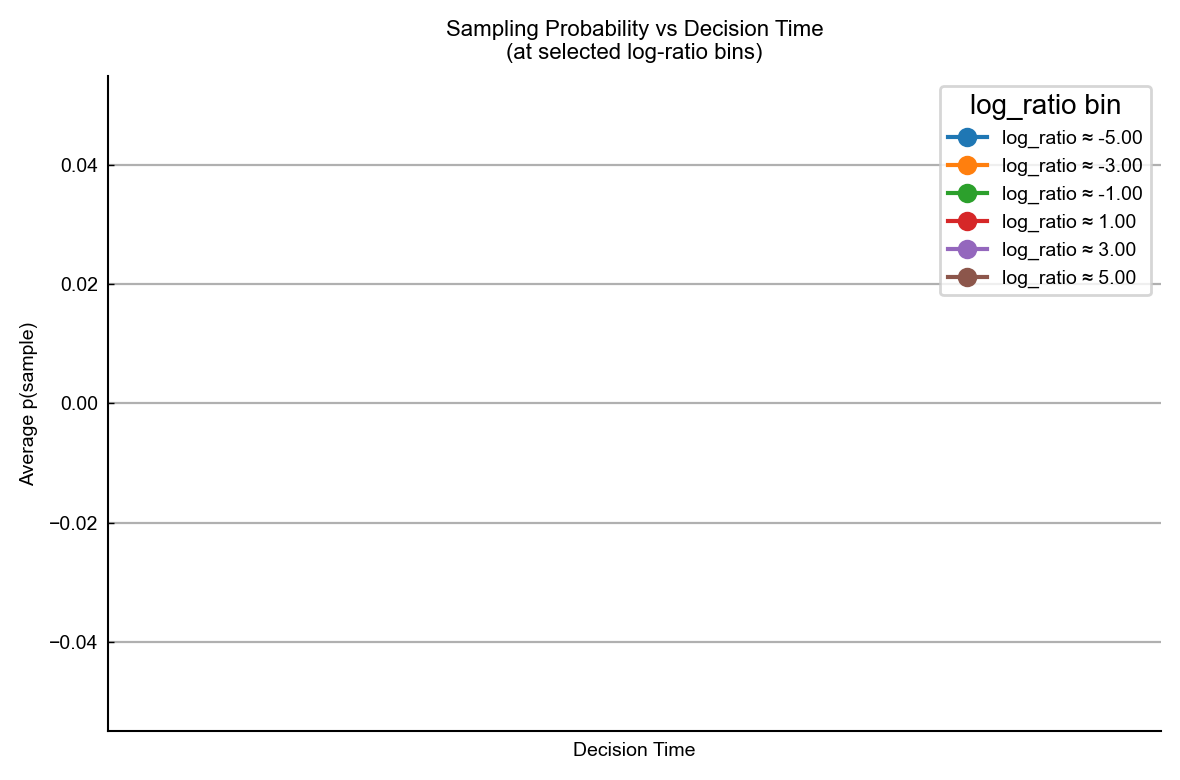

In [79]:
# 挑选想要显示的 log_bin 中心值
selected_bin_centers = [-5.0, -3.0, -1.0, 1.0, 3.0, 5.0]

# 精度控制：找最接近 bin_center 的 bin
df_selected = df_binned[df_binned['bin_center'].round(2).isin([round(bc, 2) for bc in selected_bin_centers])]

# 重新绘图：x 轴为 decision_time，y 轴为 p_sample，每条线是一个 log_bin
fig, ax = plt.subplots(figsize=(6, 4))

# 颜色映射
colors = cm.tab10.colors  # 使用 tab10 色系来区分不同的 bin

for i, center in enumerate(selected_bin_centers):
    subset = df_selected[df_selected['bin_center'].round(2) == round(center, 2)]
    ax.plot(subset['decision_time'],
            subset['p_sample'],
            marker='o',
            color=colors[i % len(colors)],
            label=f'log_ratio ≈ {center:.2f}')

ax.set_xlabel('Decision Time')
ax.set_ylabel('Average p(sample)')
ax.set_title('Sampling Probability vs Decision Time\n(at selected log-ratio bins)')
ax.set_xticks(sorted(df_selected['decision_time'].unique()))
ax.grid(True)
ax.legend(title='log_ratio bin')

plt.tight_layout()
plt.show()

In [100]:
df_dt2 = df_decision[df_decision['decision_time'] == 1]
df_dt2

,episode,correct_answer,stimuli_so_far,current_stimulus,action,reward,policy,hidden_state,decision_time,time_step,evidences,evidence_sum,p_chooseA,p_chooseB,p_sample,log_ratio,evidence_sum_bin,log_ratio_bin,evidence_center,log_ratio_center
31,6,0,[3],3,0,1.0,"[0.0313343033, 4.07364e-05, 0.9686249495]","[0.08688883480000001, 0.0531552322, -0.1524944...",1,1,[-0.3],-0.3,3.133430e-02,0.000041,0.968625,2.886037,"(-0.4, -0.3]","(1.968, 2.95]",-0.35,2.4590
112,20,0,[2],2,0,1.0,"[0.1344994009, 7.1368e-06, 0.865493536]","[0.0942933038, 0.1202854067, -0.1649050266, 0....",1,1,[-0.5],-0.5,1.344994e-01,0.000007,0.865494,4.275217,"(-0.6, -0.5]","(3.933, 4.915]",-0.55,4.4240
140,25,0,[2],2,0,1.0,"[0.1344994009, 7.1368e-06, 0.865493536]","[0.0942933038, 0.1202854067, -0.1649050266, 0....",1,1,[-0.5],-0.5,1.344994e-01,0.000007,0.865494,4.275217,"(-0.6, -0.5]","(3.933, 4.915]",-0.55,4.4240
207,37,1,[7],7,1,1.0,"[2.405e-07, 0.39957237240000004, 0.6004273891]","[0.0151792765, -0.0146414265, 0.0400795713, 0....",1,1,[0.9],0.9,2.405000e-07,0.399572,0.600427,-6.220480,"(0.8, 0.9]","(-6.872, -5.89]",0.85,-6.3810
214,39,1,[6],6,1,1.0,"[1.5545000000000001e-06, 0.2567133307, 0.74328...","[0.0320919156, -0.07170030470000001, -0.020094...",1,1,[0.7],0.7,1.554500e-06,0.256713,0.743285,-5.217858,"(0.6, 0.7]","(-5.89, -4.908]",0.65,-5.3990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245458,49936,0,[5],5,1,0.0,"[7.5915e-06, 0.0856905803, 0.9143018723]","[0.038972225, 0.0095360503, 0.0114389062, 0.08...",1,1,[0.5],0.5,7.591500e-06,0.085691,0.914302,-4.052605,"(0.4, 0.5]","(-4.908, -3.925]",0.45,-4.4165
245534,49949,0,[3],3,0,1.0,"[0.0313343033, 4.07364e-05, 0.9686249495]","[0.08688883480000001, 0.0531552322, -0.1524944...",1,1,[-0.3],-0.3,3.133430e-02,0.000041,0.968625,2.886037,"(-0.4, -0.3]","(1.968, 2.95]",-0.35,2.4590
245625,49966,0,[7],7,1,0.0,"[2.405e-07, 0.39957237240000004, 0.6004273891]","[0.0151792765, -0.0146414265, 0.0400795713, 0....",1,1,[0.9],0.9,2.405000e-07,0.399572,0.600427,-6.220480,"(0.8, 0.9]","(-6.872, -5.89]",0.85,-6.3810
245649,49972,0,[2],2,0,1.0,"[0.1344994009, 7.1368e-06, 0.865493536]","[0.0942933038, 0.1202854067, -0.1649050266, 0....",1,1,[-0.5],-0.5,1.344994e-01,0.000007,0.865494,4.275217,"(-0.6, -0.5]","(3.933, 4.915]",-0.55,4.4240
